In [1]:
import sys

sys.path.append(".")

import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from utils import read_msi
from pathlib import Path
from scipy import ndimage
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from pyimzml.ImzMLParser import ImzMLParser

# Define current folder using this file
CWD = "."
# Define folder that contains the revision chip type dataset
BASE_PATH = Path(os.path.join(CWD, "..", "data", "LONGITUDINAL"))
# Define folder that contains raw data
RAW_DATA = BASE_PATH.joinpath("raw")
# Define folder to save aligned data
ALIGNED_DATA = BASE_PATH.joinpath("aligned")
# Define folder to save processed data
PROCESSED_DATA = BASE_PATH.joinpath("processed")

In [2]:
def read_image_info(folder_name):
  msi_path = PROCESSED_DATA / folder_name / 'meaningful_signal.imzML'
  msi_seg = np.load(PROCESSED_DATA / folder_name / "segmentation_new.npy")

  with ImzMLParser(msi_path) as p:
    mzs, img = read_msi(p)
    mzs_filter = (mzs >= 600) & (mzs <= 900)
    img_filter = img[:, :, mzs_filter]

  return img_filter, mzs[mzs_filter], msi_seg


def perform_hierarchical_clustering(pixels, n_clusters):
  # Perform hierarchical clustering
  clustering = AgglomerativeClustering(
      n_clusters=n_clusters, linkage='ward', compute_distances=True
  )
  clustering.fit(pixels)
  return clustering


def plot_clusters(label_image, n_clusters=3, cbar=False):
  #
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(n_clusters)]
  colors = np.vstack(([1, 1, 1, 1], selected_colors))
  custom_cmap = ListedColormap(colors)

  #flipped_label_image = np.fliplr(label_image)
  seg_c_map = plt.imshow(label_image, cmap=custom_cmap, vmin=0, vmax=n_clusters)
  if cbar:
    cbar = plt.colorbar(
        seg_c_map, ticks=np.arange(1, n_clusters + 1),
        boundaries=np.arange(0.5, n_clusters + 1.5)
    )
    cbar.set_ticklabels(range(1, n_clusters + 1))
    cbar.set_label(
        'Cluster', labelpad=15, fontweight='bold', fontsize=14, color='0.2'
    )
    cbar.outline.set_edgecolor('0.2')
    cbar.ax.tick_params(labelsize=14, width=2.5, color='0.2')
    for l in cbar.ax.get_yticklabels():
      l.set_fontweight('bold')
      l.set_color('0.2')
  plt.axis('off')
  plt.tight_layout()
  plt.show()


def get_sample_name(s):
  if len(s.split("rep_")) > 1:
    return "day_" + s.split("day_")[1].split("_"
                                            )[0] + "_rep_" + s.split("rep_")[1]
  return "day_" + s.split("day_")[1].split("_")[0]

In [3]:
samples_groups = [
    ["tmz_1_tumor_brain_3_day_0_0_uM", "tmz_1_tumor_brain_3_day_5_0_uM_rep_1"],
    [
        "tmz_2_tumor_brain_3_day_0_1000_uM",
        "tmz_2_tumor_brain_3_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_4_day_0_0_uM", "tmz_tumor_brain_4_day_5_0_uM_rep_2"],
    [
        "tmz_tumor_brain_4_day_0_1000_uM",
        "tmz_tumor_brain_4_day_5_1000_uM_rep_2"
    ], ["tmz_tumor_brain_5_day_0_0_uM", "tmz_tumor_brain_5_day_5_0_uM_rep_3"],
    [
        "tmz_2_tumor_brain_5_day_0_1000_uM",
        "tmz_2_tumor_brain_5_day_5_1000_uM_rep_3"
    ], ["tmz_tumor_brain_6_day_0_0_uM", "tmz_tumor_brain_6_day_5_0_uM_rep_3"],
    [
        "tmz_tumor_brain_6_day_0_1000_uM",
        "tmz_tumor_brain_6_day_5_1000_uM_rep_2"
    ]
]

In [4]:
load_models = True

save_path = Path("./longitudinal/hca_gaussian_new/")
save_path.mkdir(parents=True, exist_ok=True)

gaussian_sigma = 1.0
n_clusters = 4

img_list = []
mzs_list = []
seg_list = []
cluster_labels_list = []

for sample in np.array(samples_groups).flatten():
  img, mzs, seg = read_image_info(sample)

  mzs_list.append(mzs)
  seg_list.append(seg)

  img[~seg] = 0

  img_smoothed = ndimage.gaussian_filter(img, sigma=gaussian_sigma)
  img_scaled = np.zeros_like(img)
  img_scaled[seg] = MinMaxScaler(clip=True).fit_transform(img_smoothed[seg])
  img_with_res = np.zeros_like(img)
  for i, mz in enumerate(mzs):
    mzs_mask = (mzs >= mz - 0.025) & (mzs <= mz + 0.025)
    img_with_res[:, :, i] = np.sum(img_scaled[:, :, mzs_mask], axis=-1)
  img_list.append(img_with_res)

  if load_models:
    hca = joblib.load(save_path / f"{sample}.pkl")
  else:
    hca = perform_hierarchical_clustering(img_with_res[seg], n_clusters)
    joblib.dump(hca, save_path / f"{sample}.pkl")

  cluster_labels = np.zeros(img_with_res.shape[:-1])
  cluster_labels[seg] = hca.labels_ + 1
  cluster_labels_list.append(cluster_labels)

  print(sample)
  plot_clusters(cluster_labels, n_clusters)

Cluster map max correlation: {1.0: 0.4454, 2.0: 0.7942, 3.0: 0.724, 4.0: 0.7471}
Cluster map from day 5 to day 0: {1.0: 3.0, 2.0: 4.0, 3.0: 2.0, 4.0: 2.0}
Cluster map max correlation: {1.0: 0.8159, 2.0: 0.5526, 3.0: 0.4741, 4.0: 0.6317}
Cluster map from day 5 to day 0: {1.0: 1.0, 2.0: 1.0, 3.0: 2.0, 4.0: 4.0}
Cluster map max correlation: {1.0: 0.6328, 2.0: 0.8154, 3.0: 0.5745, 4.0: 0.7098}
Cluster map from day 5 to day 0: {1.0: 4.0, 2.0: 4.0, 3.0: 3.0, 4.0: 1.0}
Cluster map max correlation: {1.0: 0.5102, 2.0: 0.7411, 3.0: 0.6027, 4.0: 0.5959}
Cluster map from day 5 to day 0: {1.0: 3.0, 2.0: 2.0, 3.0: 2.0, 4.0: 2.0}
Cluster map max correlation: {1.0: 0.5457, 2.0: 0.6623, 3.0: 0.7523, 4.0: 0.5845}
Cluster map from day 5 to day 0: {1.0: 1.0, 2.0: 2.0, 3.0: 4.0, 4.0: 1.0}
Cluster map max correlation: {1.0: 0.814, 2.0: 0.493, 3.0: 0.4122, 4.0: 0.4316}
Cluster map from day 5 to day 0: {1.0: 2.0, 2.0: 2.0, 3.0: 1.0, 4.0: 4.0}
Cluster map max correlation: {1.0: 0.5706, 2.0: 0.7657, 3.0: 0.6003

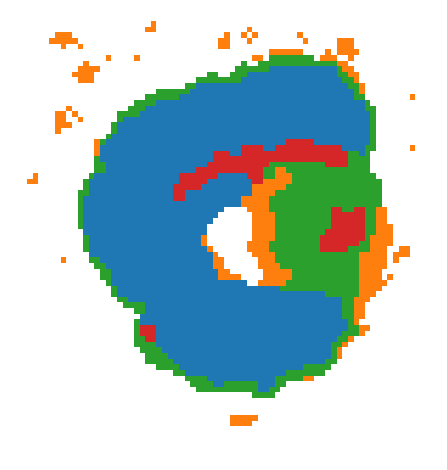

1


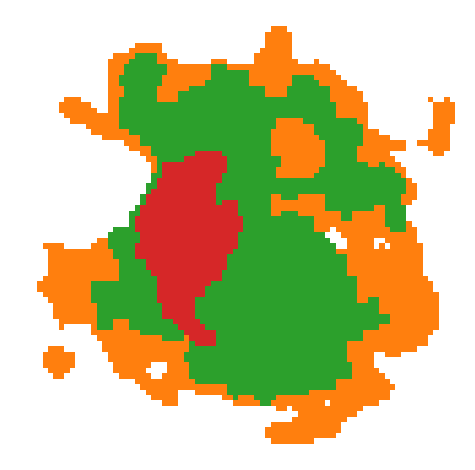

2


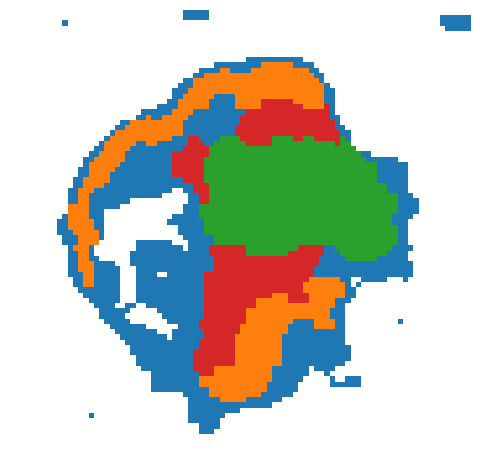

3


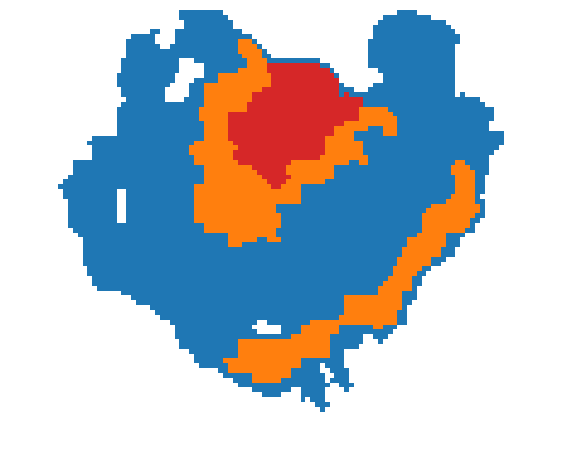

4


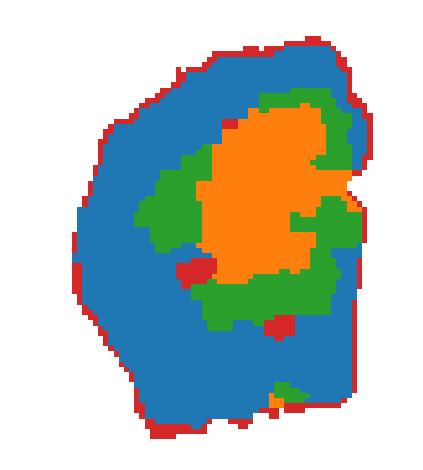

5


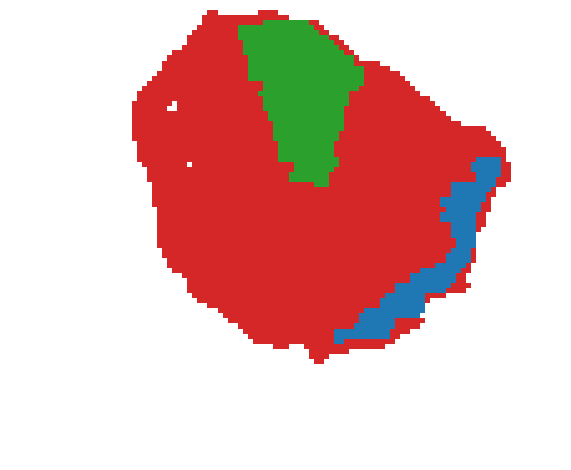

6


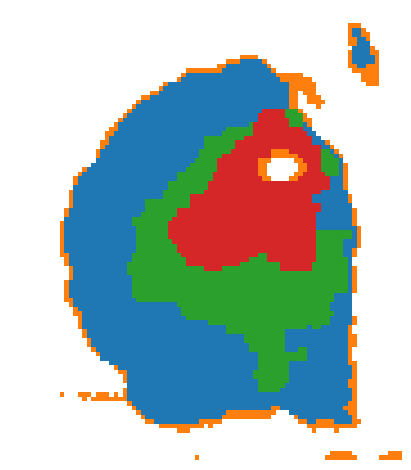

7


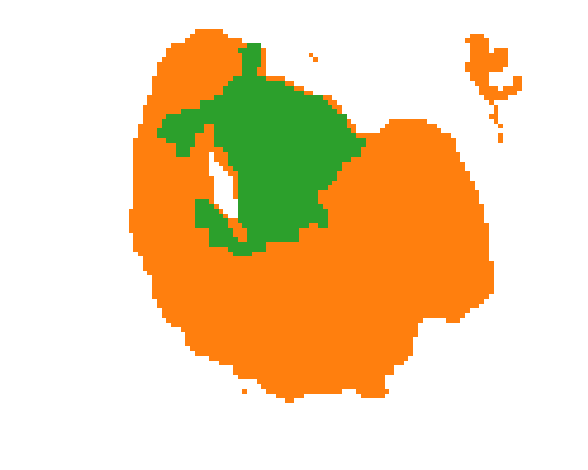

8


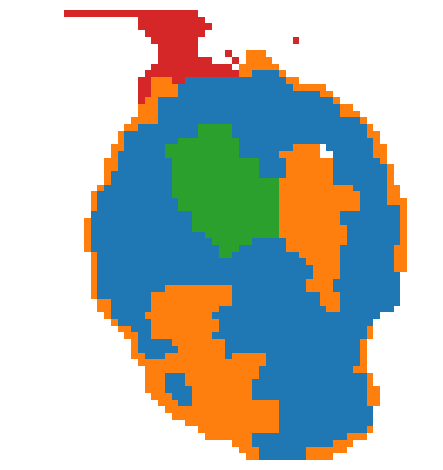

9


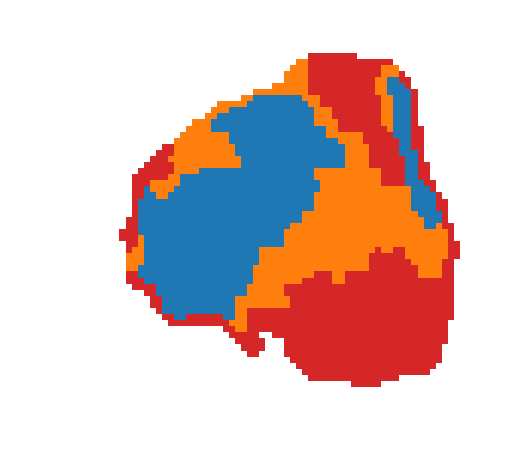

10


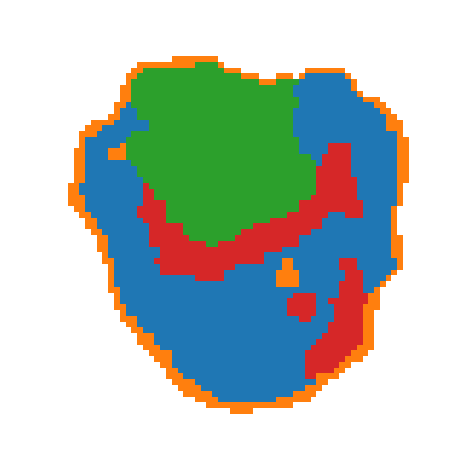

11


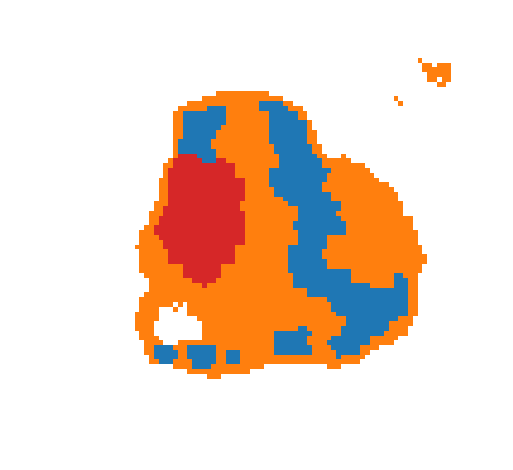

12


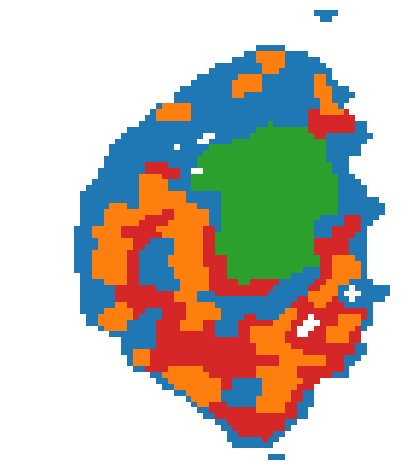

13


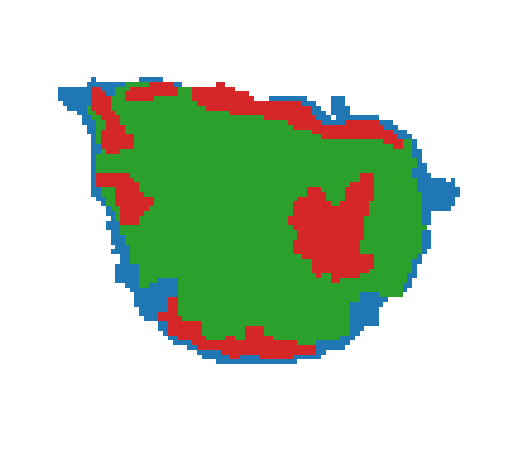

14


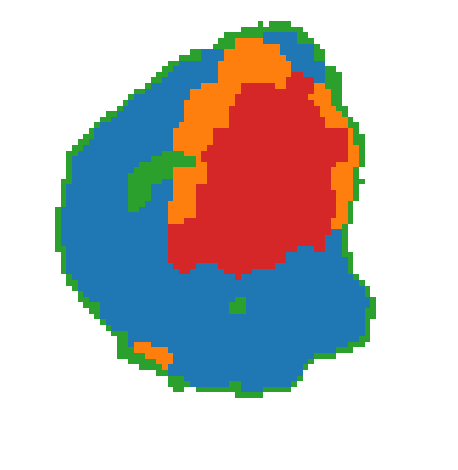

15


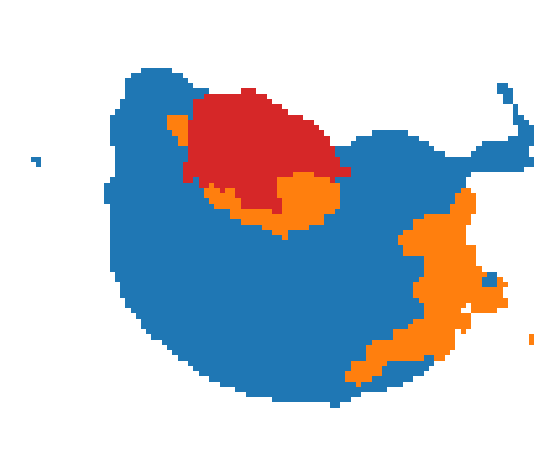

In [5]:
from copy import deepcopy

between_days_correlation = []

for sample_idx in range(0, len(samples_groups) * 2, 2):
  mean_vecs_0 = {}
  mean_vecs_5 = {}
  for cluster in np.delete(np.unique(cluster_labels_list[sample_idx]), 0):
    mean_vecs_0[cluster] = img_list[sample_idx][np.isin(cluster_labels_list[sample_idx],
                                               cluster)].mean(axis=0)
  for cluster in np.delete(np.unique(cluster_labels_list[sample_idx + 1]), 0):
    mean_vecs_5[cluster] = img_list[sample_idx + 1][
        np.isin(cluster_labels_list[sample_idx + 1], cluster)].mean(axis=0)

  correlation = []
  for key_1, value_1 in mean_vecs_0.items():
    for key_2, value_2 in mean_vecs_5.items():
      correlation.append((key_1, key_2, np.corrcoef(value_1, value_2)[0, 1]))

  between_days_correlation.append(correlation)

new_cluster_labels_list = []

for idx, correlation in enumerate(between_days_correlation):
  cluster_max_corr = {}
  cluster_map = {}

  for cluster_0, cluster_5, corr in correlation:
    if cluster_max_corr.get(cluster_5, -np.inf) < corr:
      cluster_max_corr[cluster_5] = corr
      cluster_map[cluster_5] = cluster_0

  day_5_index = idx * 2 + 1

  new_cluster_labels_list.append(cluster_labels_list[idx * 2].copy())

  cluster_labels = cluster_labels_list[day_5_index]
  new_cluster_labels = cluster_labels.copy()

  for cluster_5, cluster_0 in cluster_map.items():
    new_cluster_labels[cluster_labels == cluster_5] = cluster_0
  
  new_cluster_labels_list.append(new_cluster_labels)

  print("Cluster map max correlation:", {key: round(value, 4) for key, value in cluster_max_corr.items()})
  print("Cluster map from day 5 to day 0:", cluster_map)

for i, new_cluster_labels in enumerate(new_cluster_labels_list):
  print(i)
  plot_clusters(new_cluster_labels, n_clusters)

In [6]:
from sklearn.manifold import TSNE


def plot_tsne(data, labels):
  tab10_cmap = plt.get_cmap('tab10')
  selected_colors = [tab10_cmap(i) for i in range(3)]

  # Create and fit the t-SNE model
  tsne = TSNE(n_components=2, random_state=42)
  tsne_result = tsne.fit_transform(data)

  # Create a DataFrame to easily handle the results and labels
  df_tsne = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])

  df_tsne['Label'] = labels

  # Plot the t-SNE results
  plt.figure(figsize=(10, 7))
  for label in sorted(df_tsne['Label'].unique()):
    subset = df_tsne[df_tsne['Label'] == label]
    plt.scatter(
        subset['Component 1'],
        subset['Component 2'],
        label=label,
        #color=selected_colors[int(label) - 1]
    )

  #plt.title('t-SNE plot')
  #plt.xlabel('Component 1')
  #plt.ylabel('Component 2')
  plt.legend()
  plt.show()

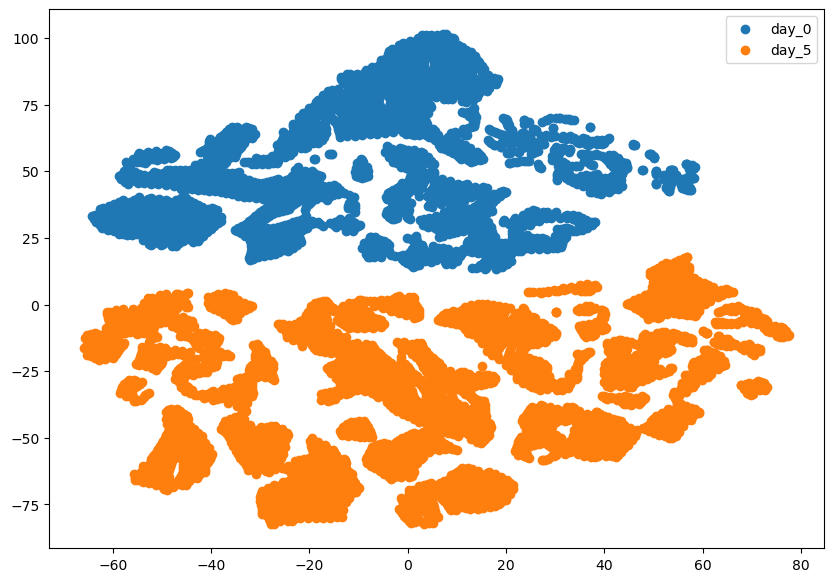

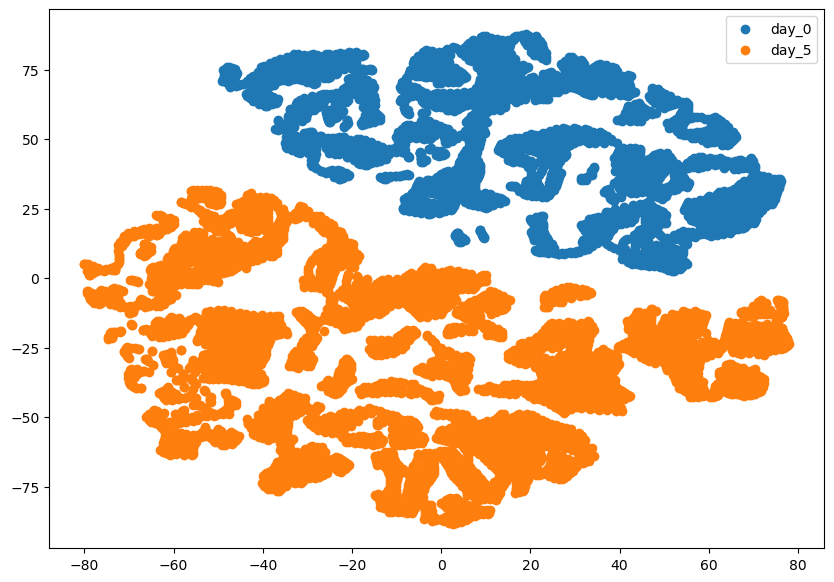

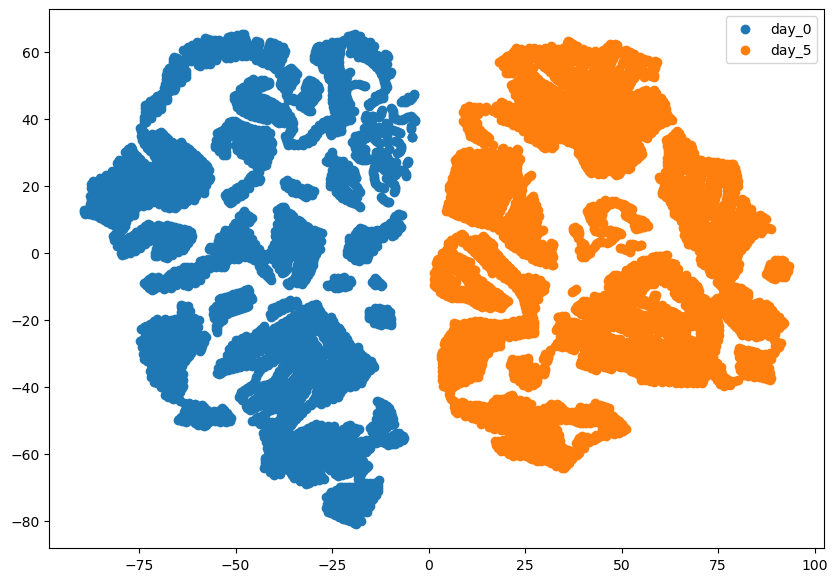

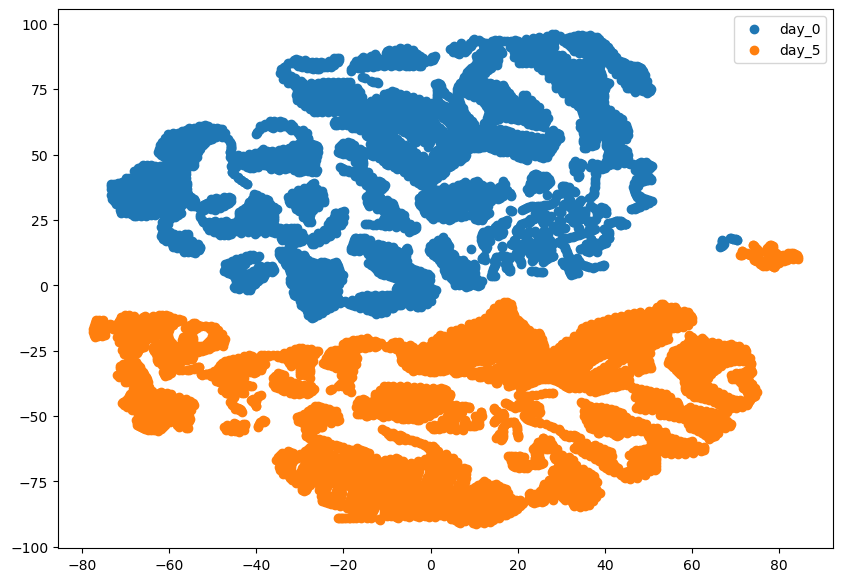

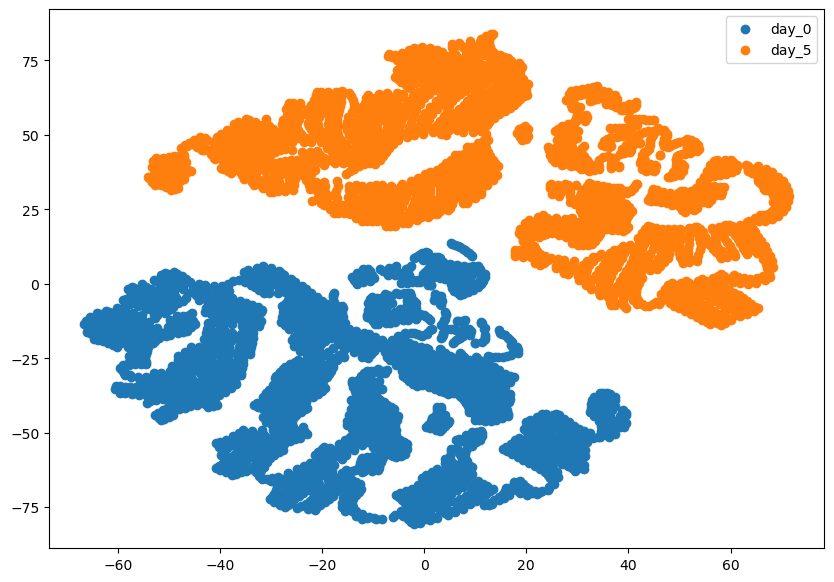

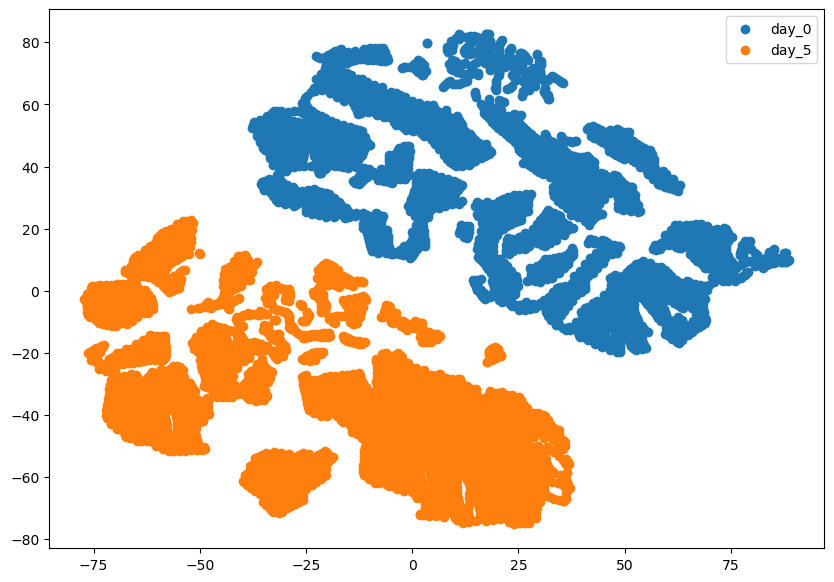

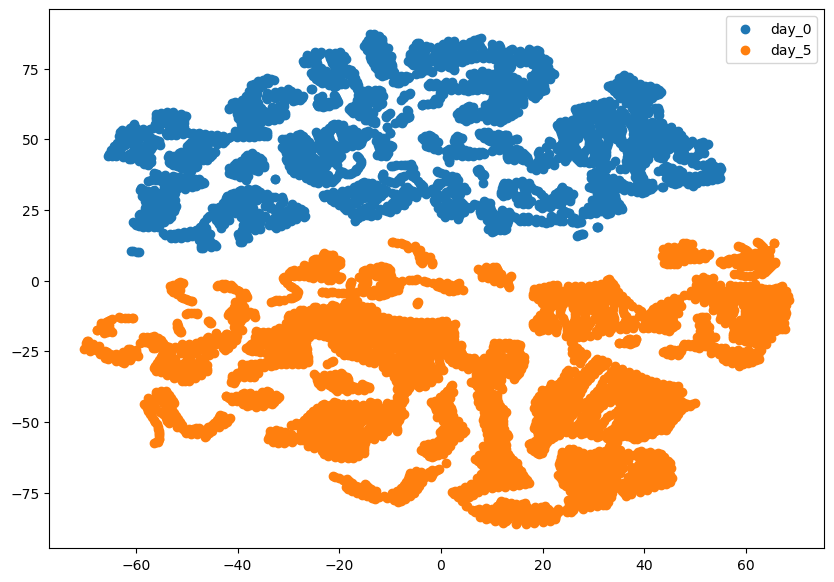

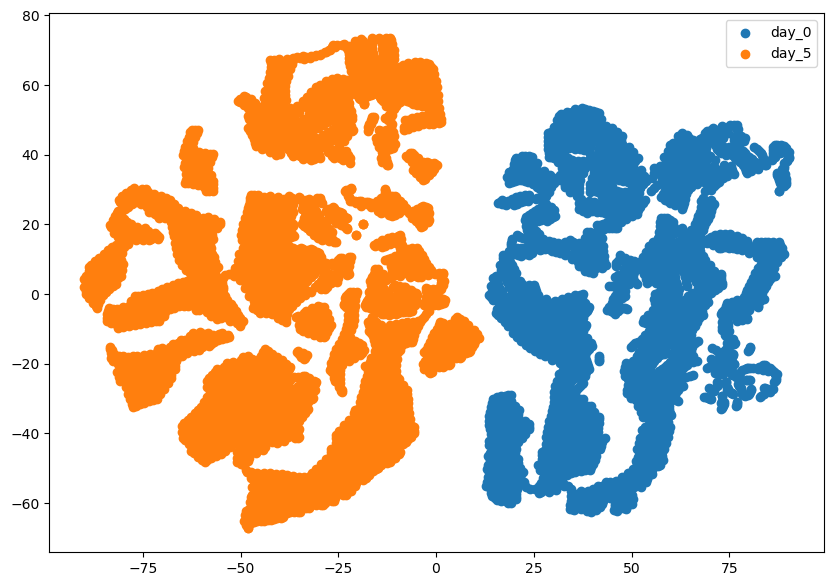

In [8]:
for i in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [img_list[i][seg_list[i]], img_list[i + 1][seg_list[i + 1]]]
      ),
      np.concatenate(
          [
              ["day_0"] * img_list[i][seg_list[i]].shape[0],
              ["day_5"] * img_list[i + 1][seg_list[i + 1]].shape[0]
          ]
      )
  )

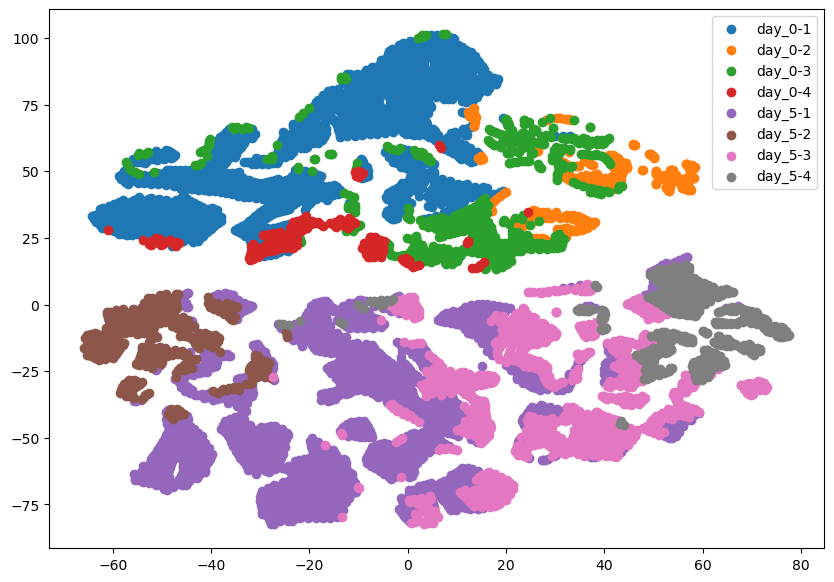

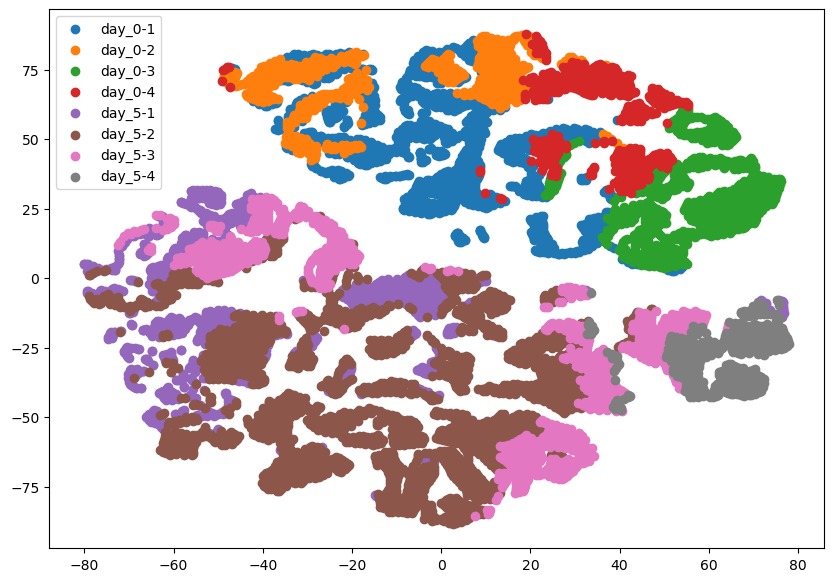

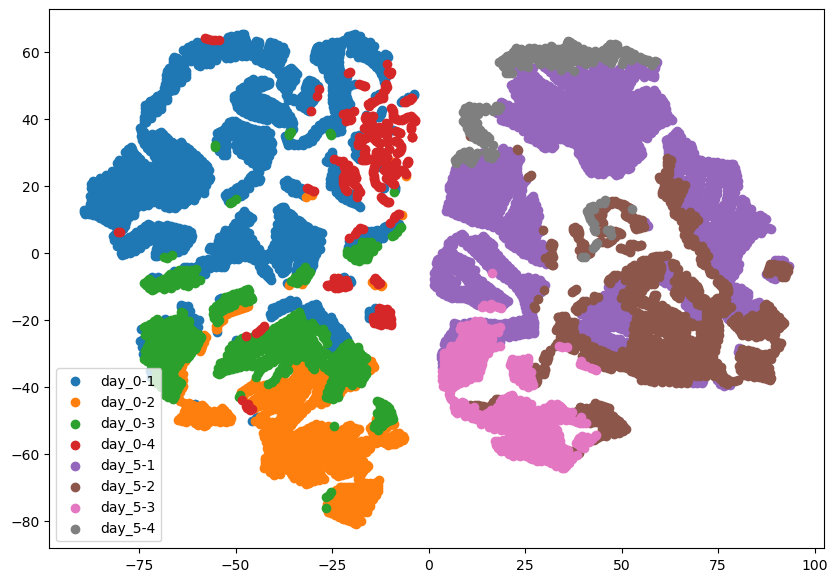

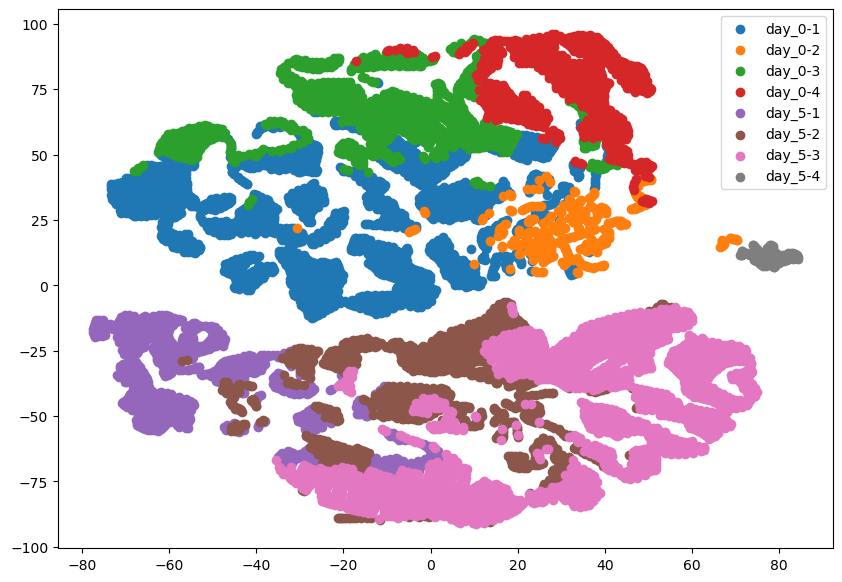

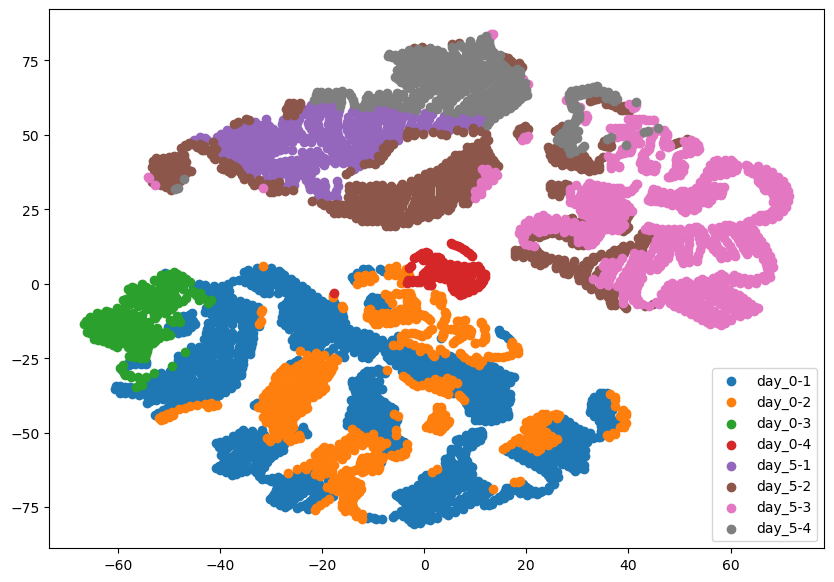

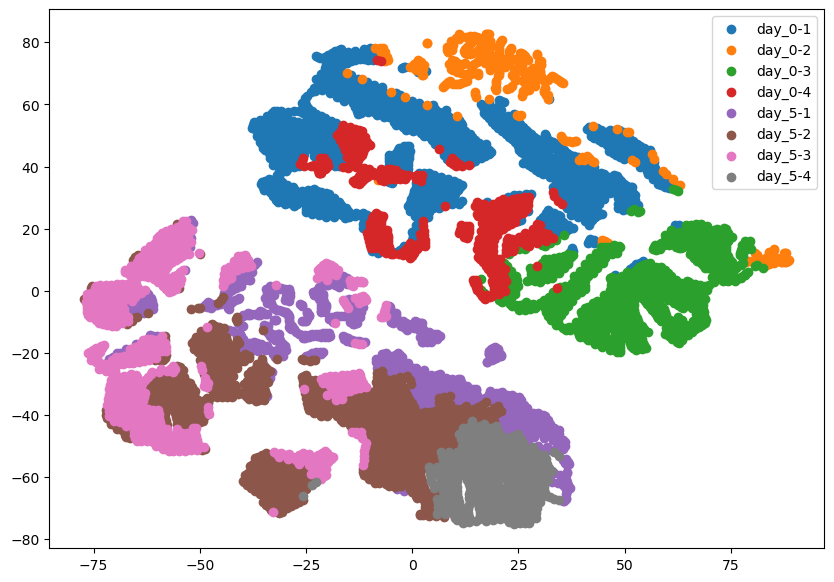

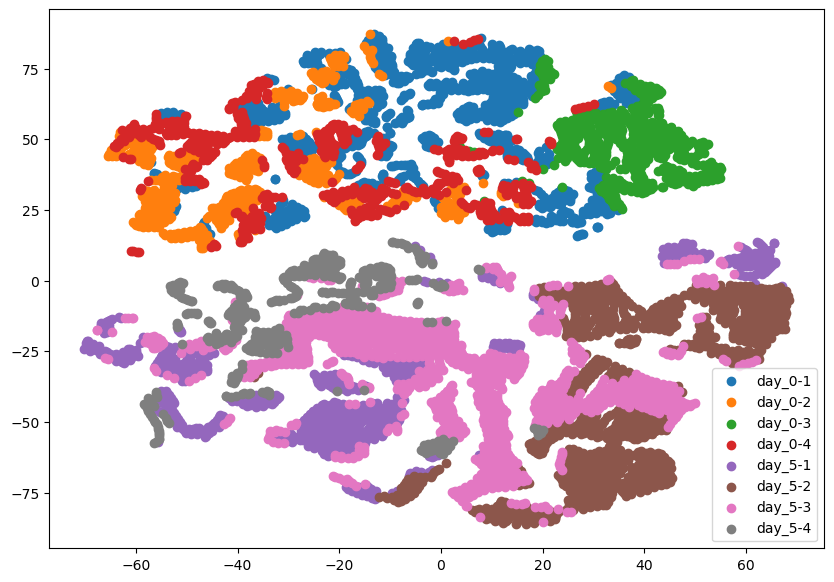

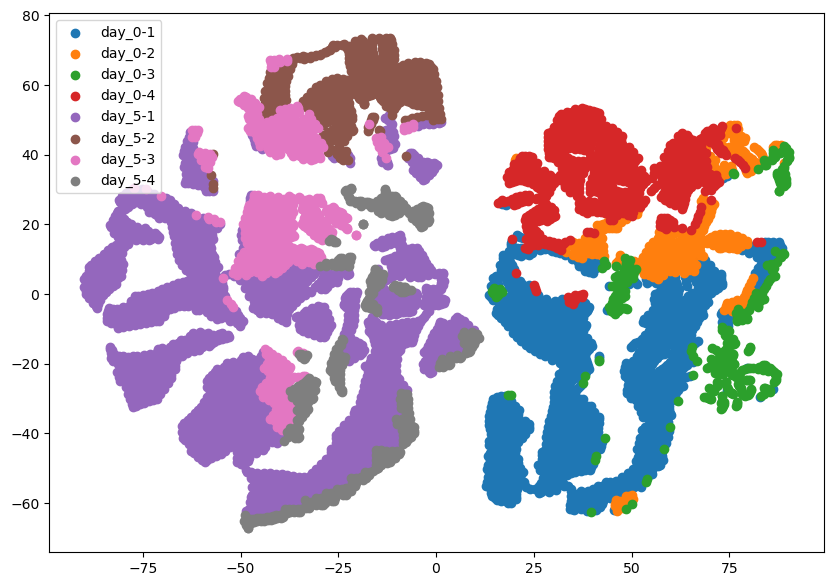

In [9]:
for i in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [img_list[i][seg_list[i]], img_list[i + 1][seg_list[i + 1]]]
      ),
      np.concatenate(
          [
              list(
                  map(
                      lambda x: f"day_0-{int(x)}",
                      cluster_labels_list[i][seg_list[i]]
                  )
              ),
              list(
                  map(
                      lambda x: f"day_5-{int(x)}",
                      cluster_labels_list[i + 1][seg_list[i + 1]]
                  )
              )
          ]
      )
  )

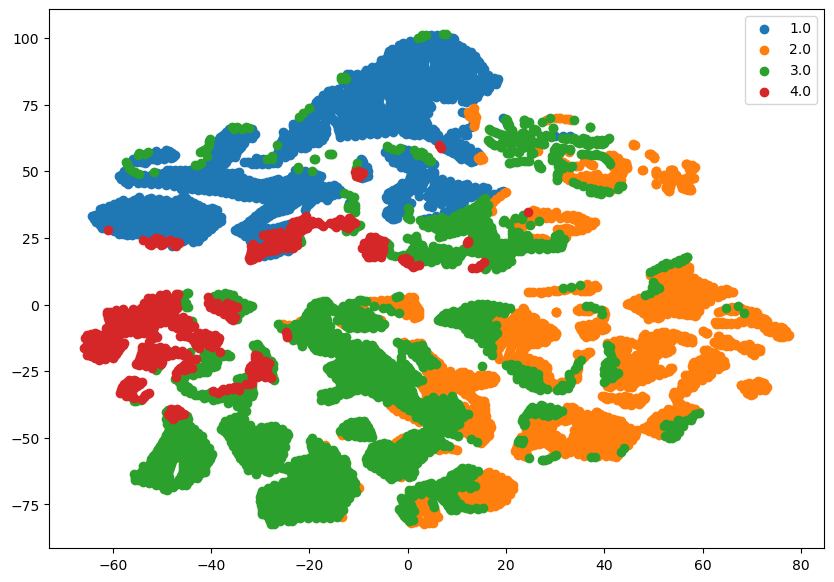

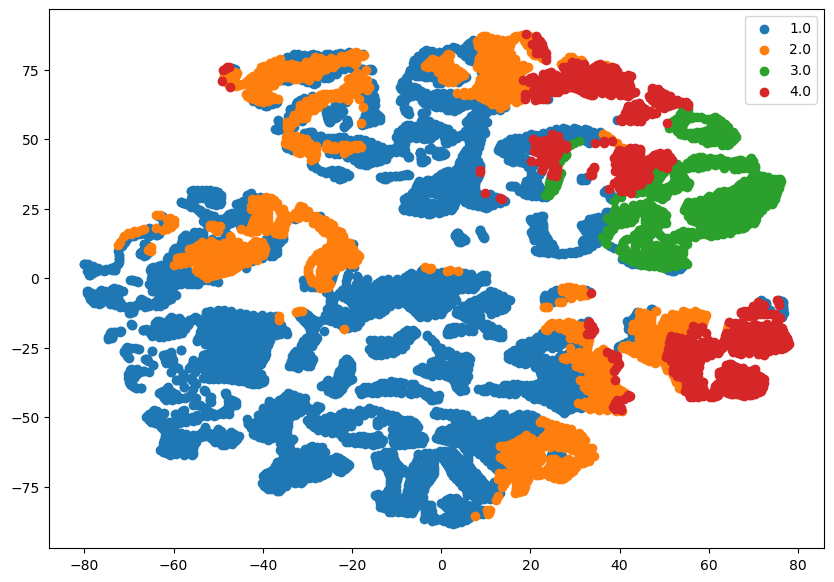

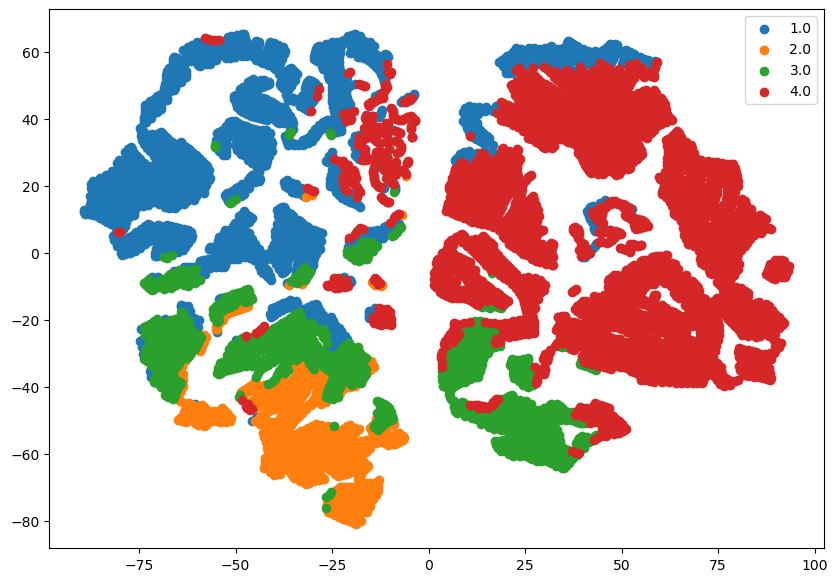

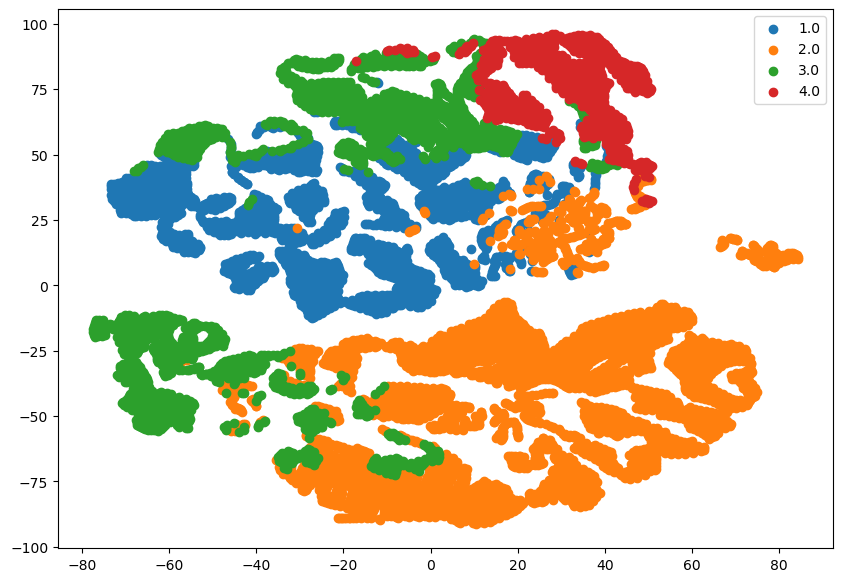

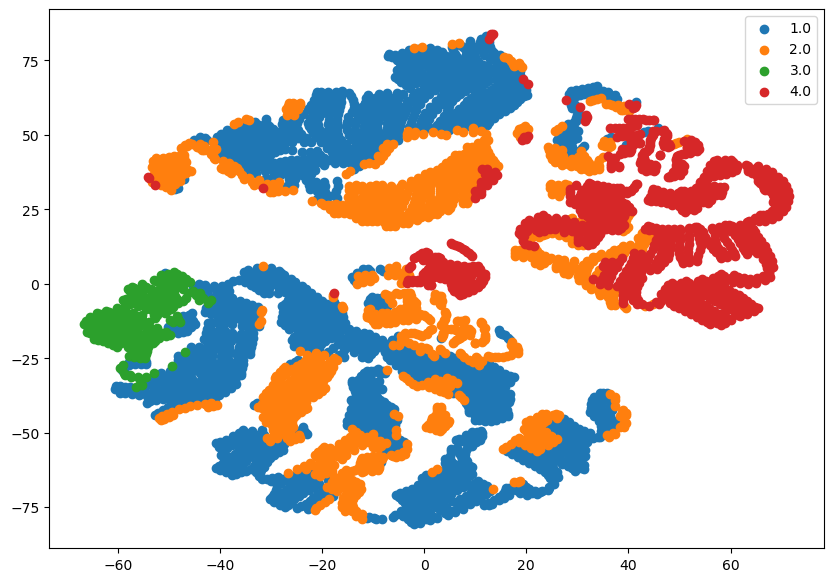

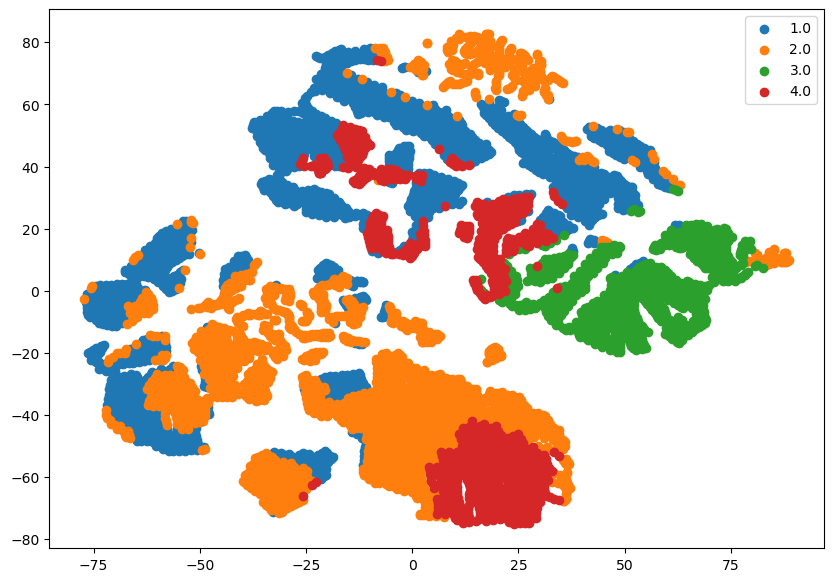

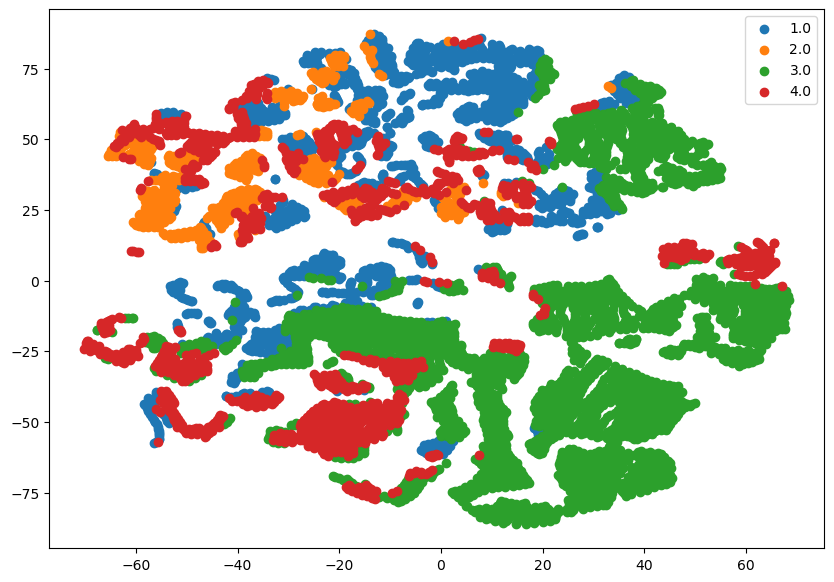

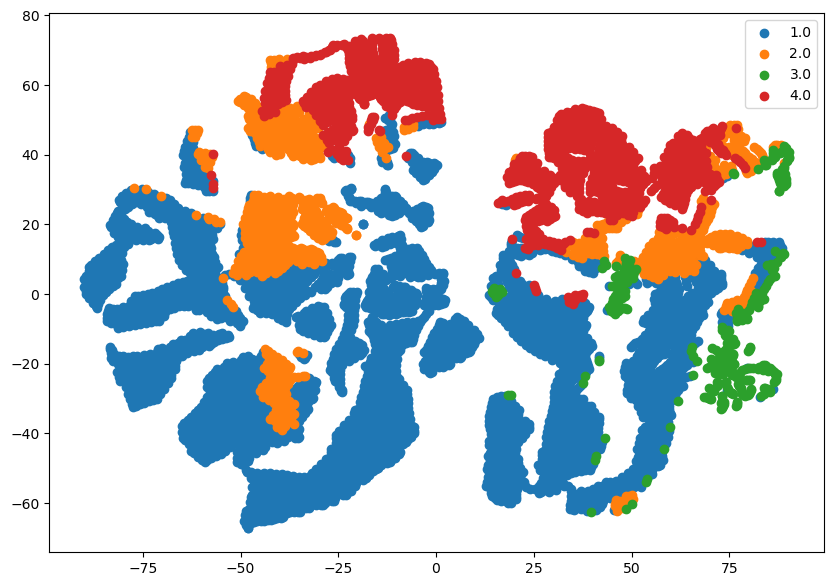

In [7]:
for i in range(0, len(samples_groups) * 2, 2):
  plot_tsne(
      np.concatenate(
          [img_list[i][seg_list[i]], img_list[i + 1][seg_list[i + 1]]]
      ),
      np.concatenate(
          [
              new_cluster_labels_list[i][seg_list[i]],
              new_cluster_labels_list[i + 1][seg_list[i + 1]]
          ]
      )
  )

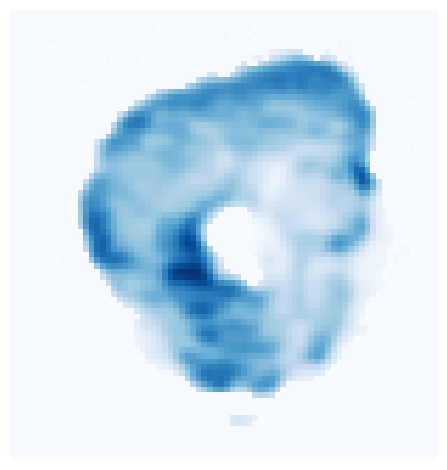

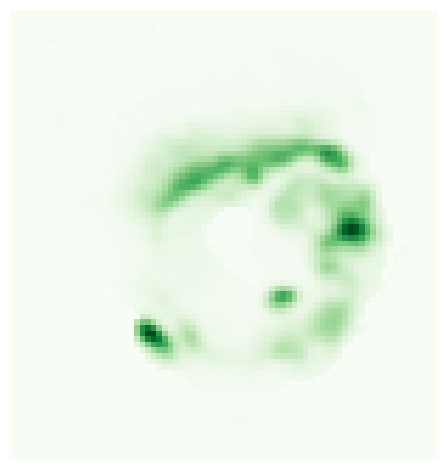

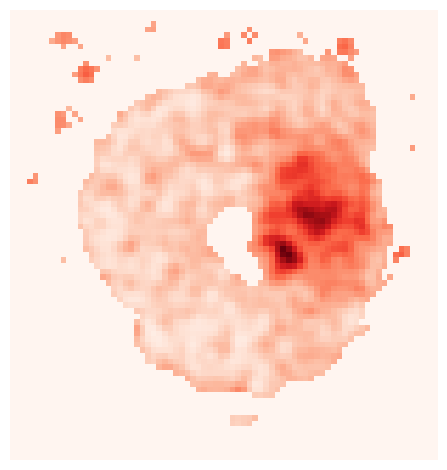

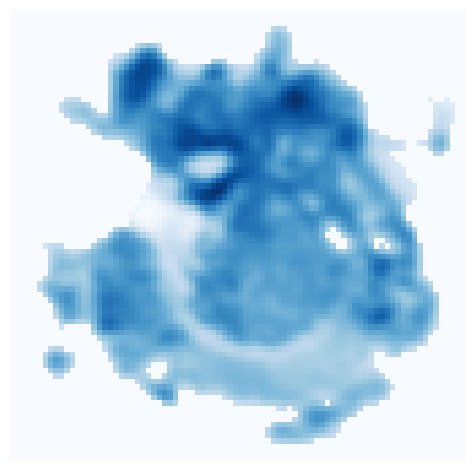

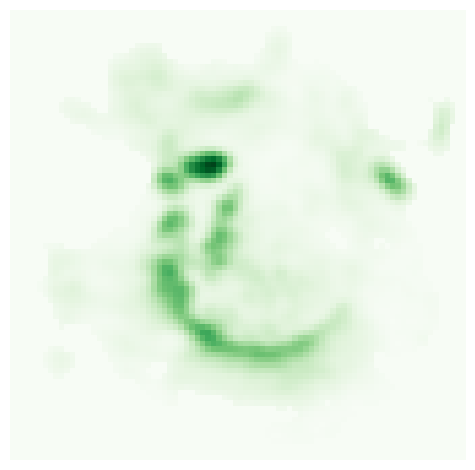

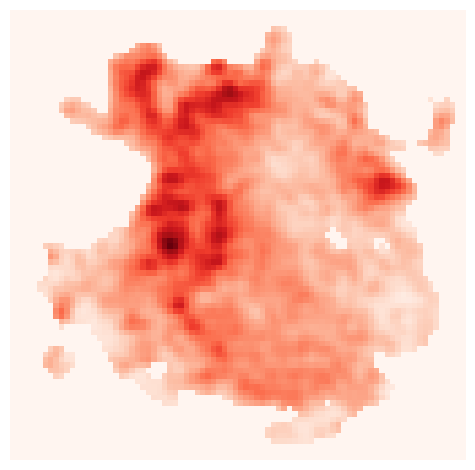

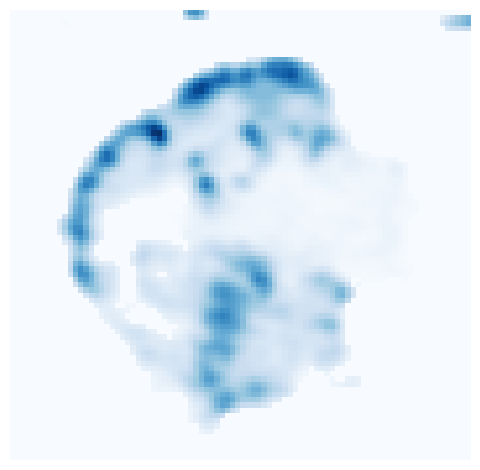

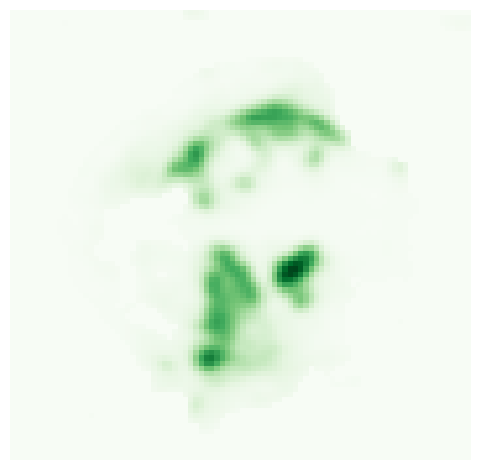

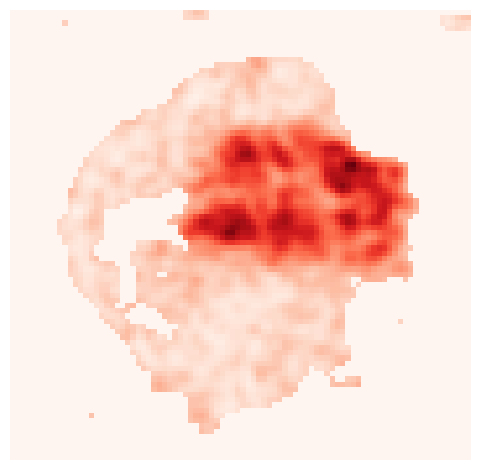

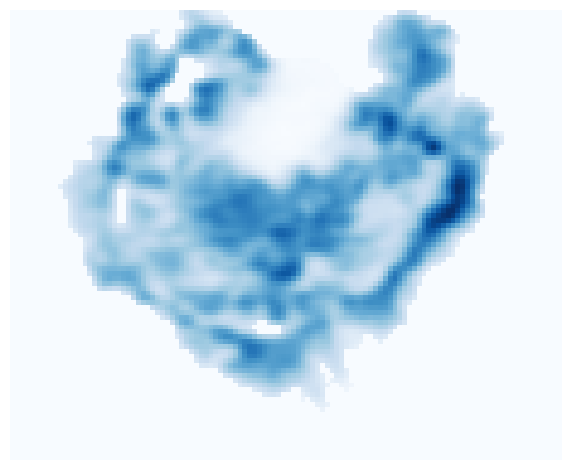

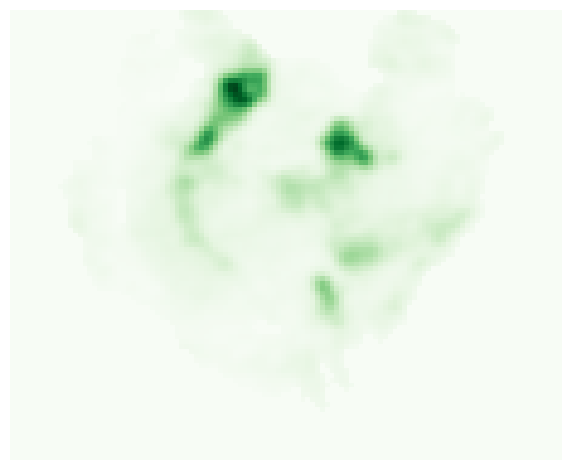

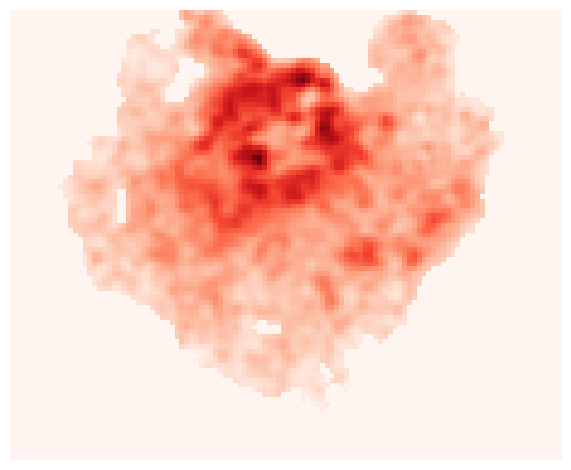

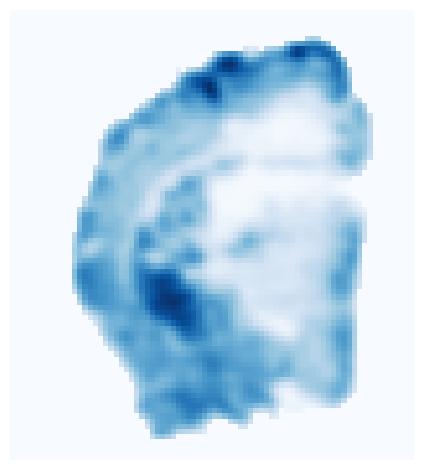

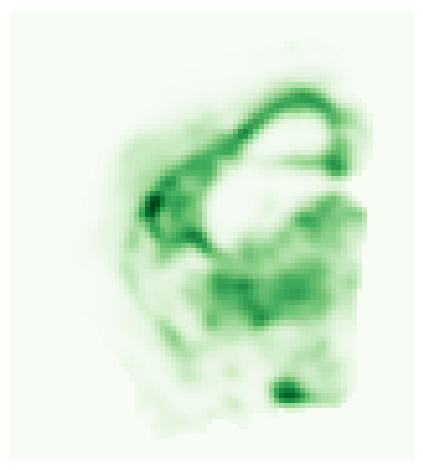

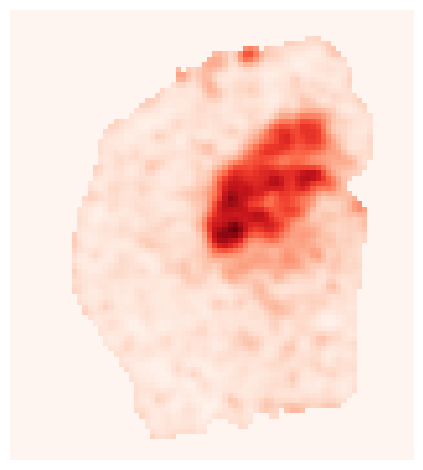

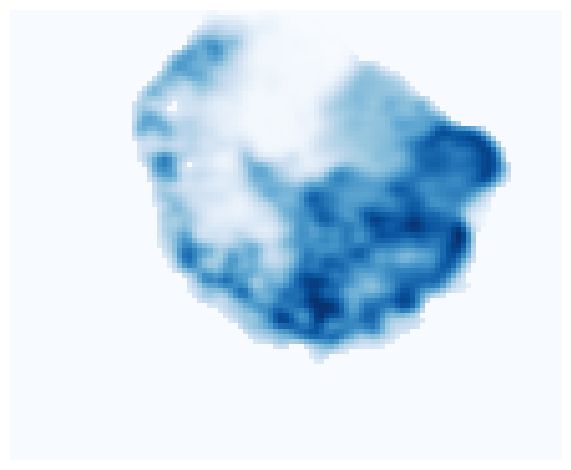

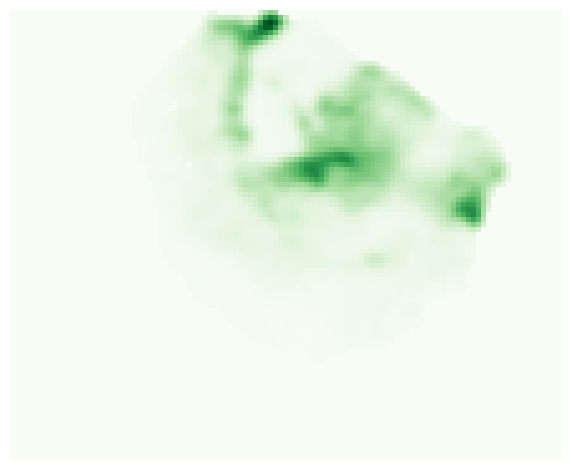

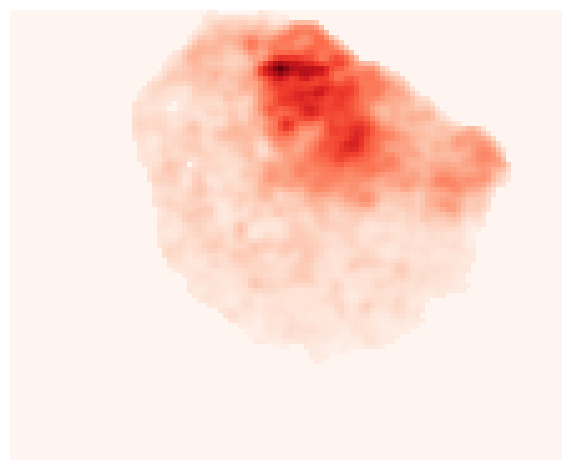

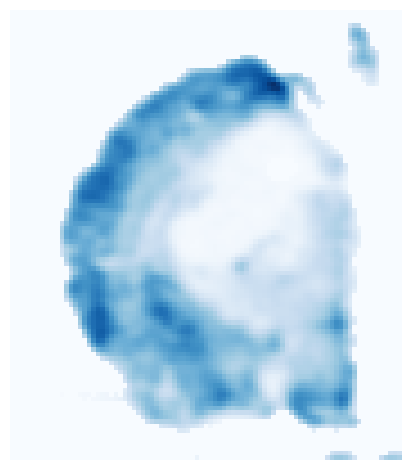

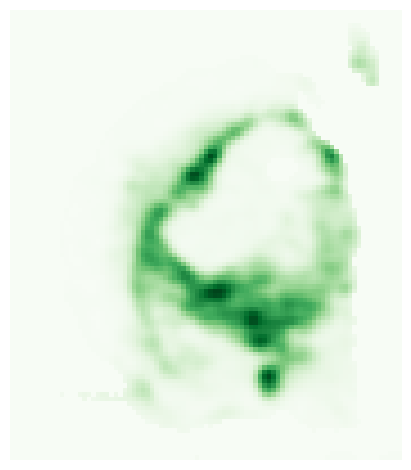

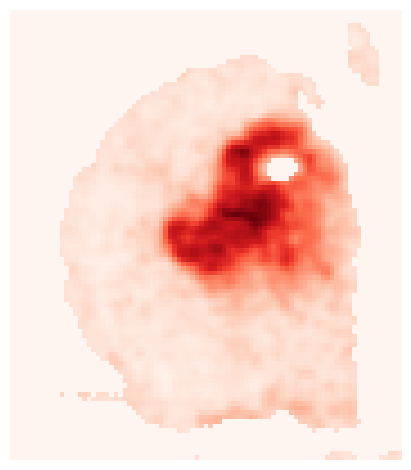

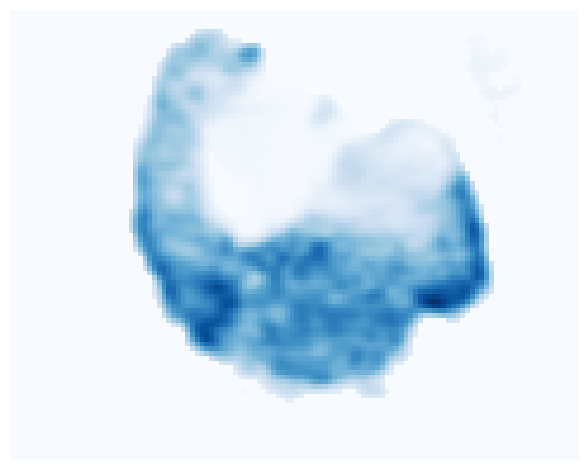

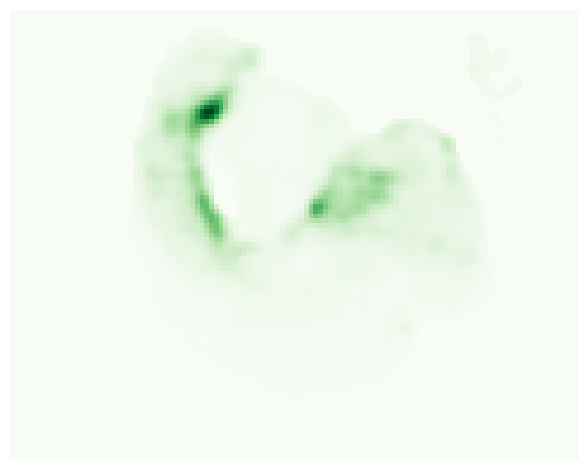

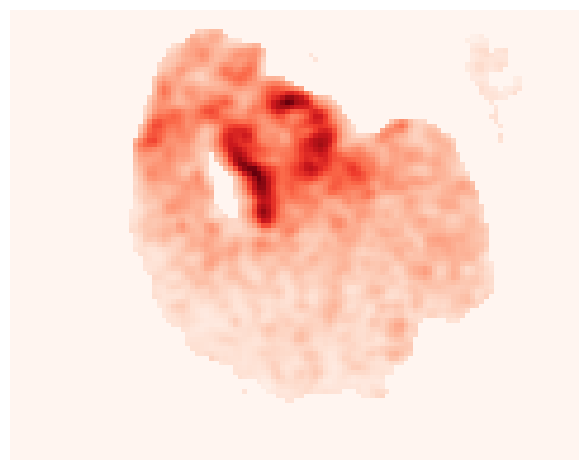

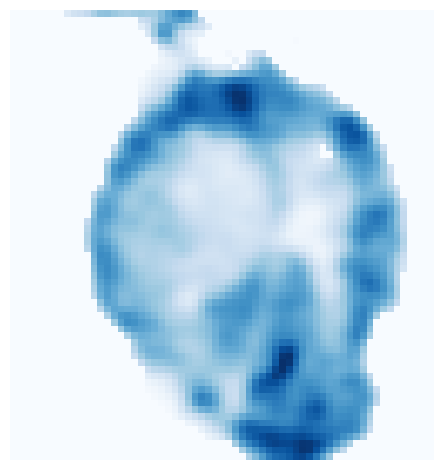

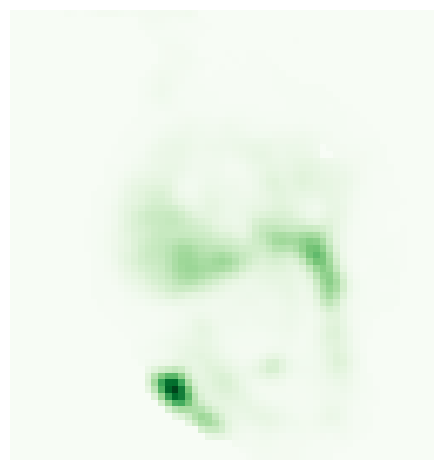

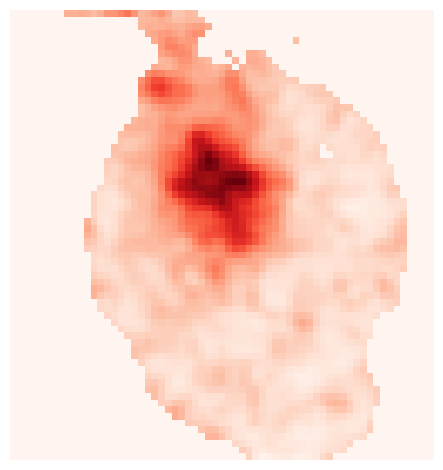

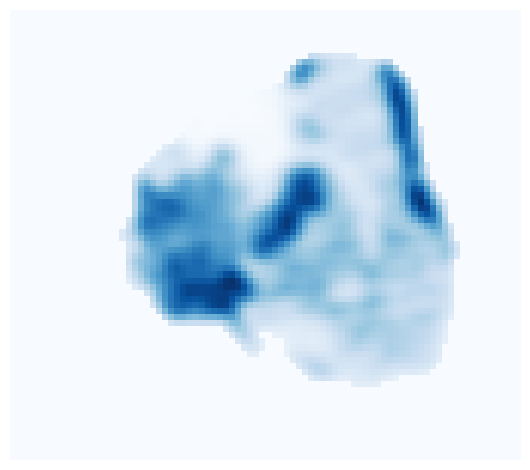

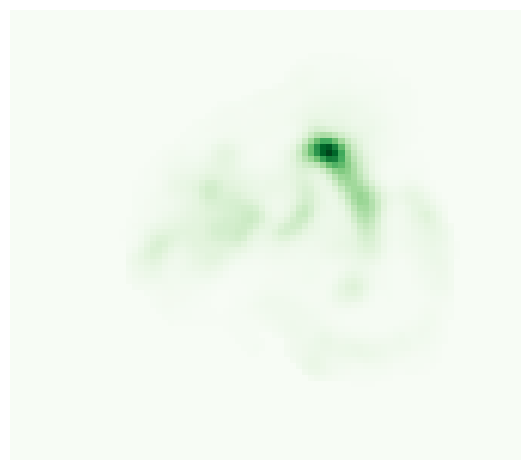

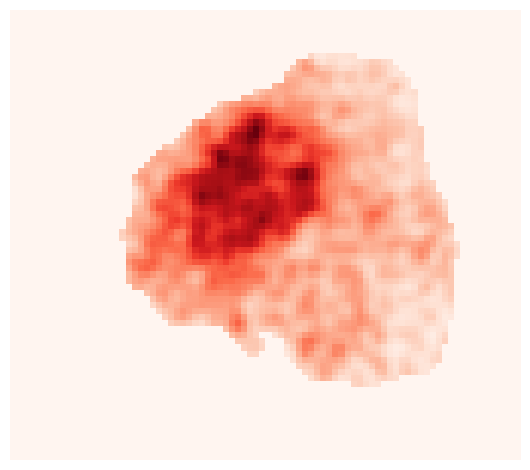

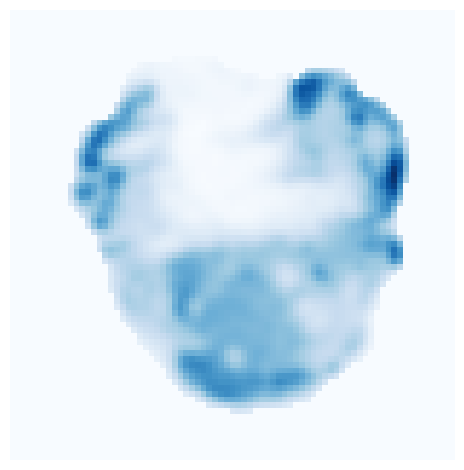

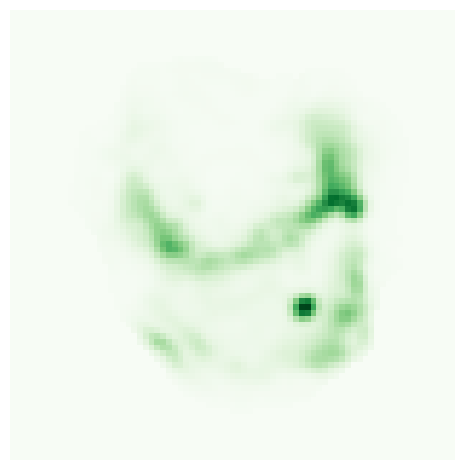

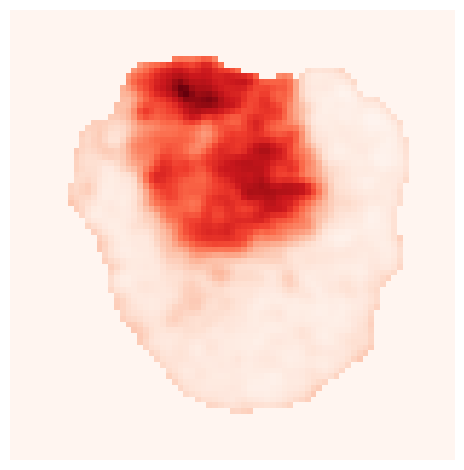

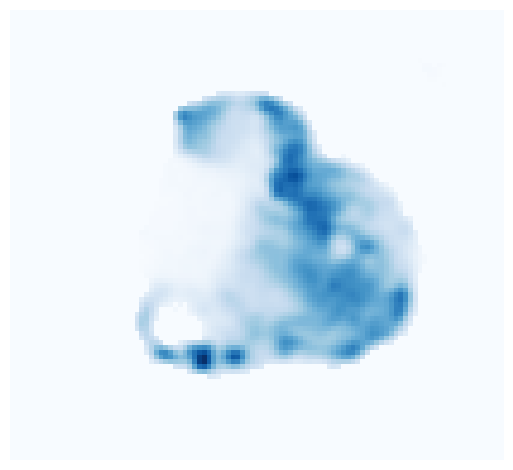

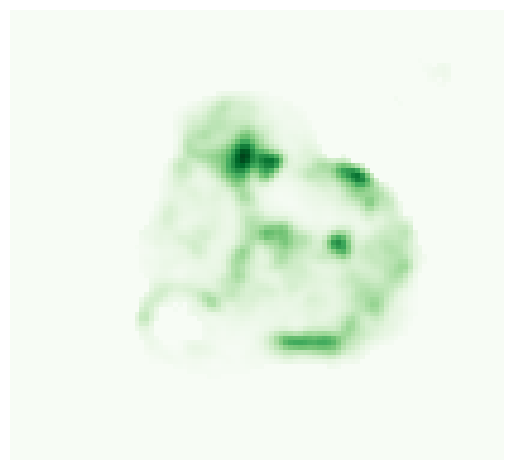

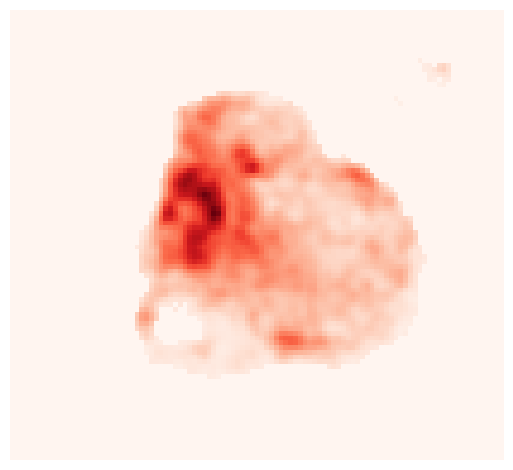

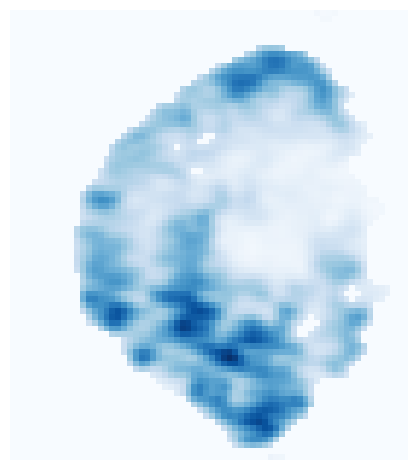

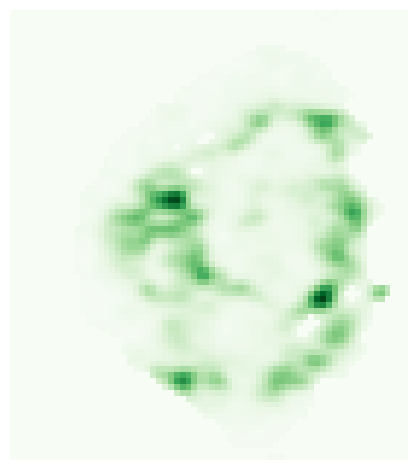

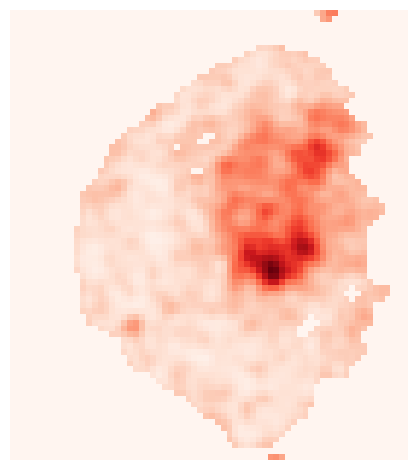

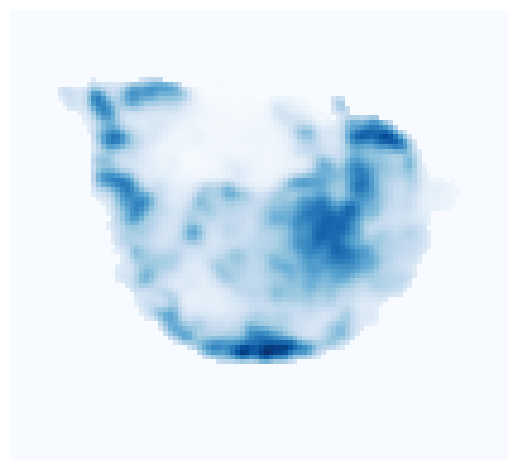

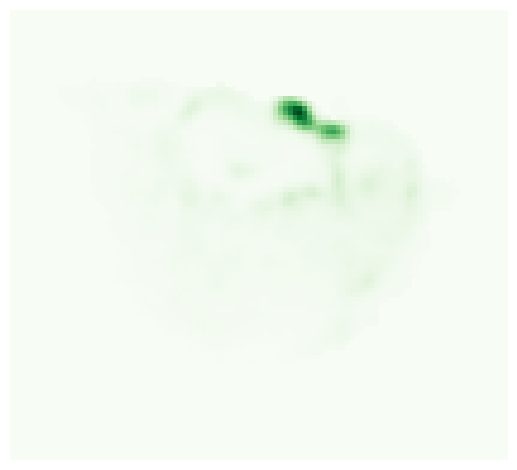

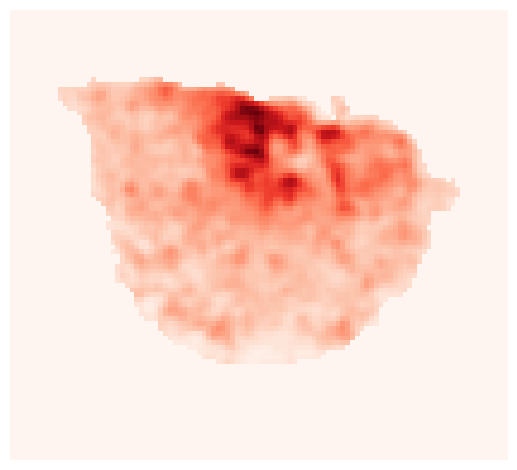

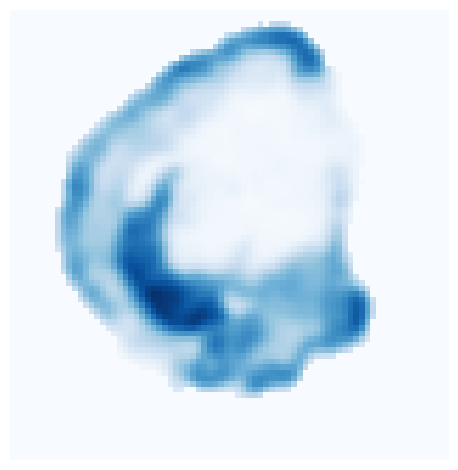

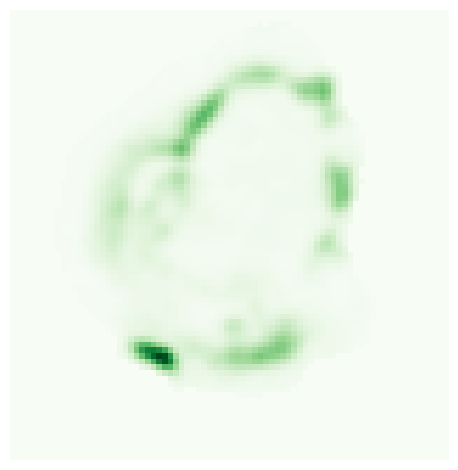

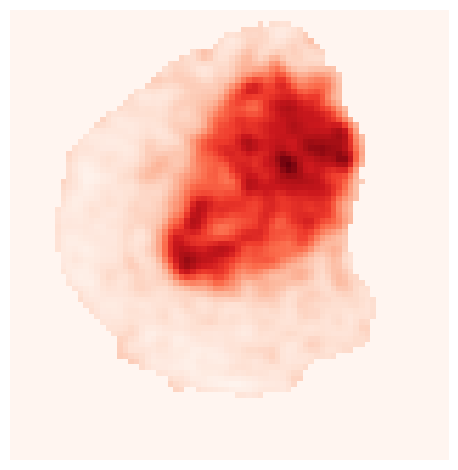

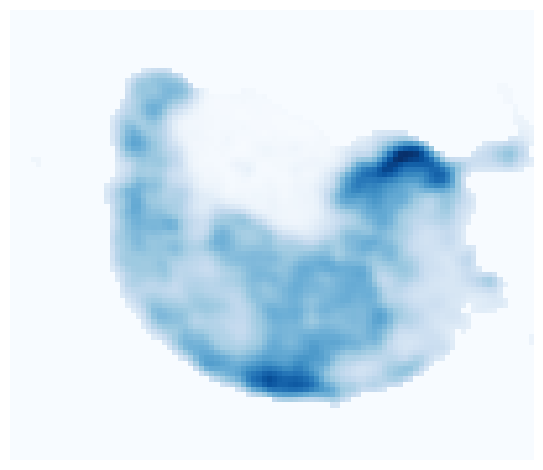

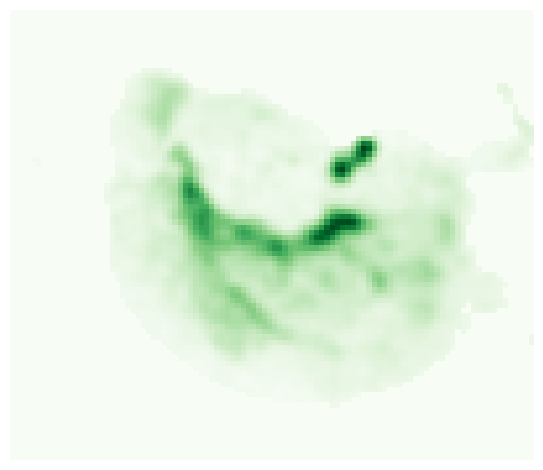

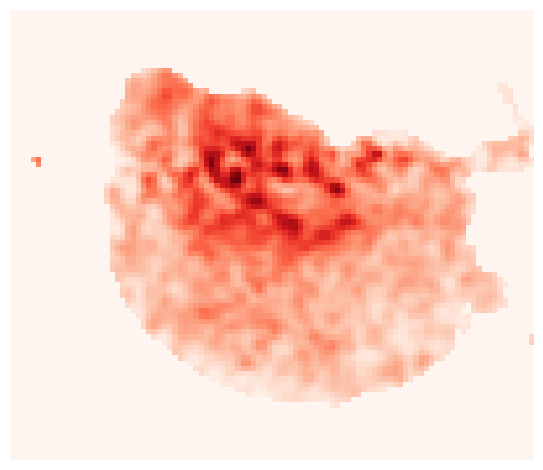

In [11]:
# For each sample, plot its 3 lipids
gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

for img in img_list:
  for color_map, name, loop_filter in zip(
      ["Blues", "Greens", "Reds"], ["gray_matter", "white_matter", "tumour"],
      [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
  ):
    plot_img = img[:, :, loop_filter].sum(axis=-1)
    plt.imshow(plot_img, cmap=color_map)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

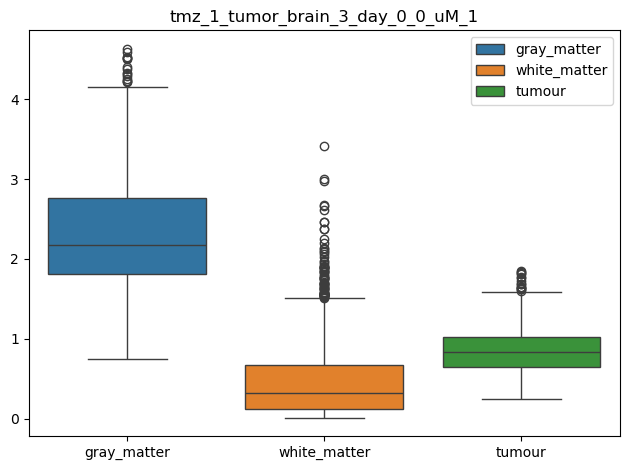

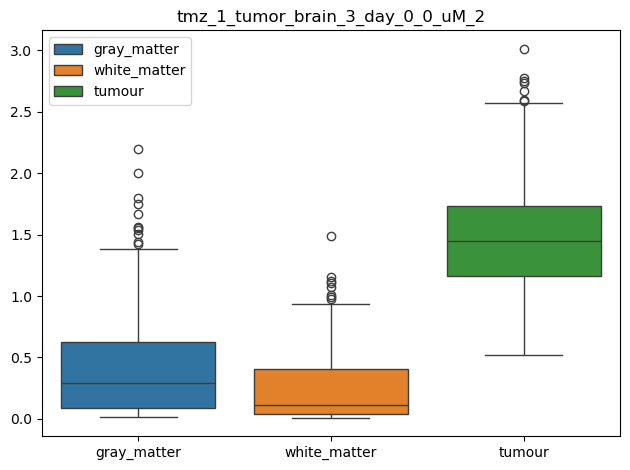

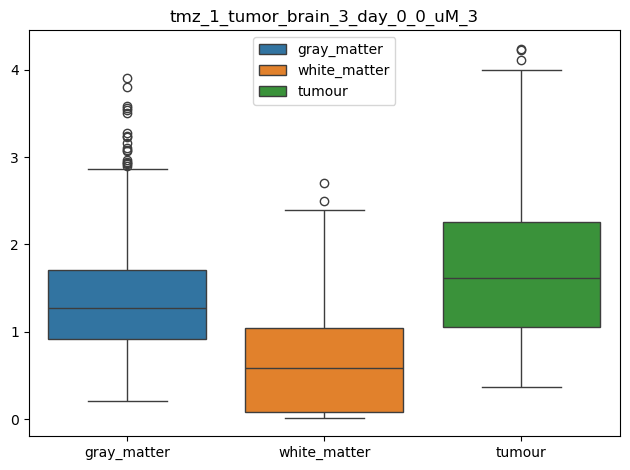

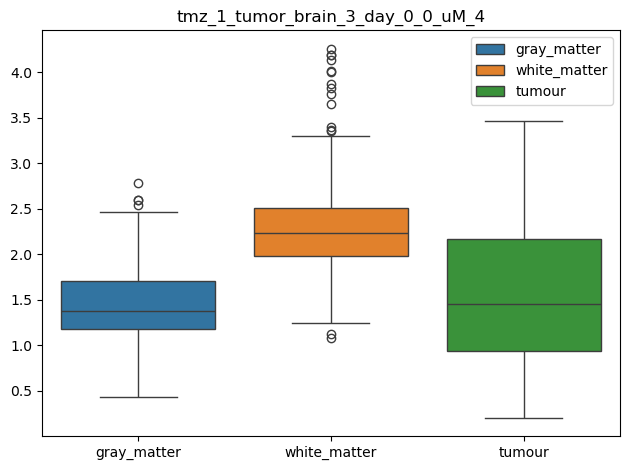

In [37]:
import seaborn as sns

gray_matter_mzs_filter = (
    (mzs_list[0] >= 600.51 - 0.025) & (mzs_list[0] <= 600.51 + 0.025)
)
tumour_mzs_filter = (
    (mzs_list[0] >= 682.64 - 0.025) & (mzs_list[0] <= 682.64 + 0.025)
)
white_matter_mzs_filter = (
    (mzs_list[0] >= 888.62 - 0.025) & (mzs_list[0] <= 888.62 + 0.025)
)

for idx, (img, clusters) in enumerate(zip(img_list, cluster_labels_list)):
  for cluster in np.delete(np.unique(clusters), 0):
    values = {}
    for name, loop_filter in zip(
        ["gray_matter", "white_matter", "tumour"],
        [gray_matter_mzs_filter, white_matter_mzs_filter, tumour_mzs_filter]
    ):
      values[name] = img[:, :, loop_filter][clusters == cluster].mean(axis=1
                                                                     ).flatten()
    sns.boxplot(pd.DataFrame.from_dict(values), legend=True)
    plt.title(f"{np.array(samples_groups).flatten()[idx]}_{int(cluster)}")
    plt.legend()
    plt.tight_layout()
    plt.show()
  break

In [15]:
img = img_list[0]
cluster_labels = cluster_labels_list[0]

img_2 = img_list[1]
cluster_labels_2 = cluster_labels_list[1]

mean_vecs = {}
for cluster in np.delete(np.unique(cluster_labels), 0):
  mean_vecs[cluster] = img[np.isin(cluster_labels, cluster)].mean(axis=0)

median_vecs = {}
for cluster in np.delete(np.unique(cluster_labels), 0):
  median_vecs[cluster] = np.median(
      img[np.isin(cluster_labels, cluster)], axis=0
  )

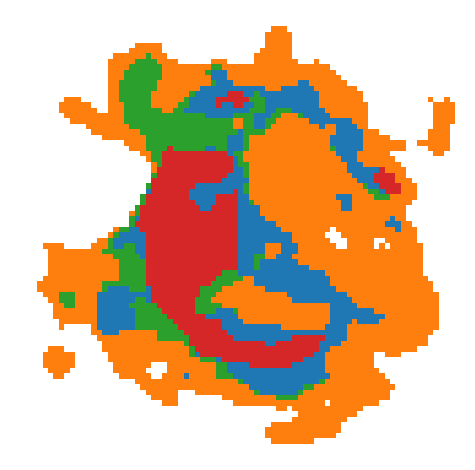

In [16]:
# Correlation approach with mean
labels = []
for vector in img_2[seg_list[1]]:
  max_corr = -np.inf
  label = None
  for cluster, mean_vec in mean_vecs.items():
    corr = np.corrcoef(vector, mean_vec)[0, 1]
    if corr > max_corr:
      max_corr = corr
      label = cluster
  labels.append(label)

new_labels = np.zeros_like(cluster_labels_2)
new_labels[seg_list[1]] = labels

plot_clusters(new_labels, n_clusters)

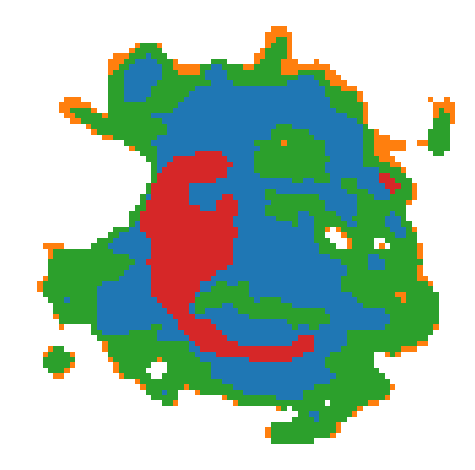

In [21]:
# Euclidean distance approach
labels = []
for vector in img_2[seg_list[1]]:
  min_dist = np.inf
  label = None
  for cluster, mean_vec in mean_vecs.items():
    dist = np.linalg.norm(vector - mean_vec)
    if dist < min_dist:
      min_dist = dist
      label = cluster
  labels.append(label)

new_labels = np.zeros_like(cluster_labels_2)
new_labels[seg_list[1]] = labels

plot_clusters(new_labels, n_clusters)

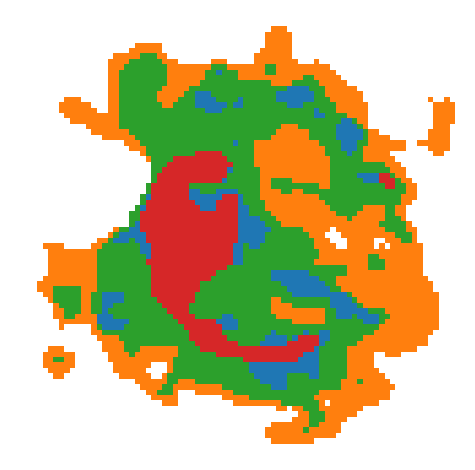

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity approach
labels = []
for vector in img_2[seg_list[1]]:
  max_sim = -1
  label = None
  for cluster, mean_vec in mean_vecs.items():
    sim = cosine_similarity([vector], [mean_vec])[0, 0]
    if sim > max_sim:
      max_sim = sim
      label = cluster
  labels.append(label)

new_labels = np.zeros_like(cluster_labels_2)
new_labels[seg_list[1]] = labels

plot_clusters(new_labels, n_clusters)

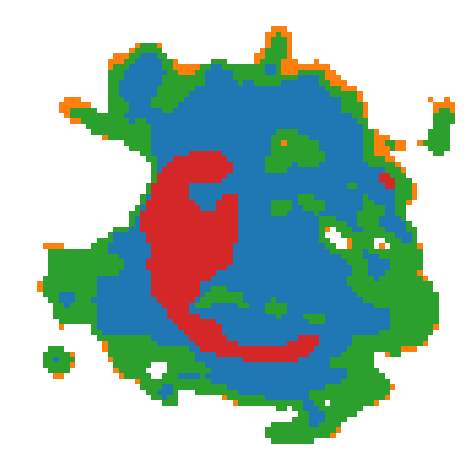

In [24]:
# Manhattan distance approach
labels = []
for vector in img_2[seg_list[1]]:
  min_dist = np.inf
  label = None
  for cluster, mean_vec in mean_vecs.items():
    dist = np.sum(np.abs(vector - mean_vec))
    if dist < min_dist:
      min_dist = dist
      label = cluster
  labels.append(label)

new_labels = np.zeros_like(cluster_labels_2)
new_labels[seg_list[1]] = labels

plot_clusters(new_labels, n_clusters)

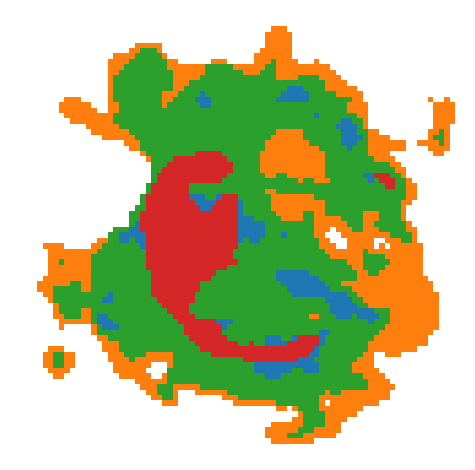

In [26]:
from scipy.stats import entropy
from tqdm.notebook import tqdm

# Kullback-Leibler Divergence approach
labels = []
for vector in img_2[seg_list[1]]:
  min_div = np.inf
  label = None
  for cluster, mean_vec in mean_vecs.items():
    div = entropy(vector, mean_vec)
    if div < min_div:
      min_div = div
      label = cluster
  labels.append(label)

new_labels = np.zeros_like(cluster_labels_2)
new_labels[seg_list[1]] = labels

plot_clusters(new_labels, n_clusters)

Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4446, 4.0: 0.4069}
Cluster map from day 5 to day 0: {1.0: 1.0, 2.0: 4.0, 3.0: 3.0, 4.0: 3.0}
Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4446, 4.0: 0.4069}
Cluster map from day 5 to day 0: {1.0: 1.0, 2.0: 3.0, 3.0: 2.0, 4.0: 4.0}
Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4446, 4.0: 0.4069}
Cluster map from day 5 to day 0: {1.0: 1.0, 2.0: 4.0, 3.0: 2.0, 4.0: 1.0}
Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4446, 4.0: 0.4069}
Cluster map from day 5 to day 0: {1.0: 3.0, 2.0: 1.0, 3.0: 1.0, 4.0: 2.0}
Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4446, 4.0: 0.4069}
Cluster map from day 5 to day 0: {1.0: 1.0, 2.0: 2.0, 3.0: 4.0, 4.0: 1.0}
Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4446, 4.0: 0.4069}
Cluster map from day 5 to day 0: {1.0: 3.0, 2.0: 4.0, 3.0: 1.0, 4.0: 4.0}
Cluster map max correlation: {1.0: 0.4525, 2.0: 0.4994, 3.0: 0.4

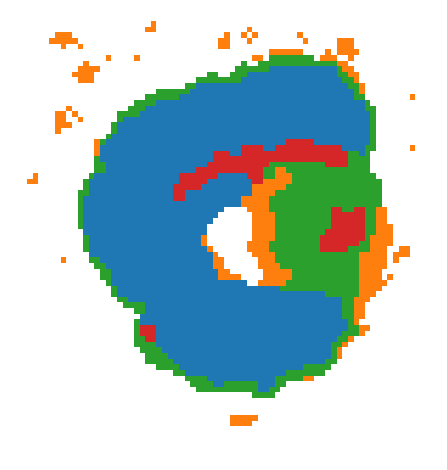

1


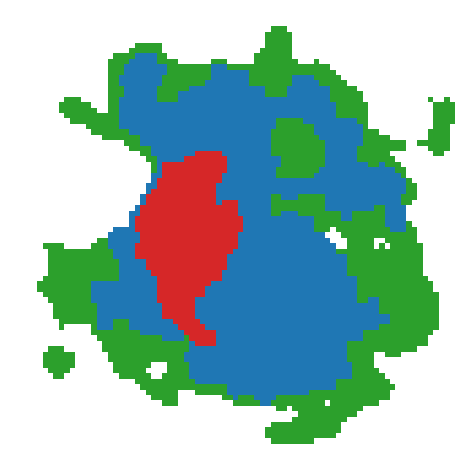

2


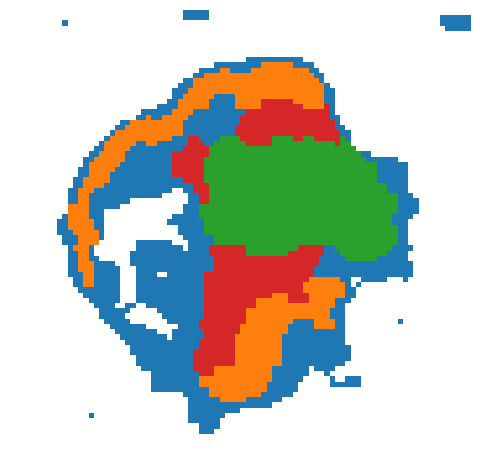

3


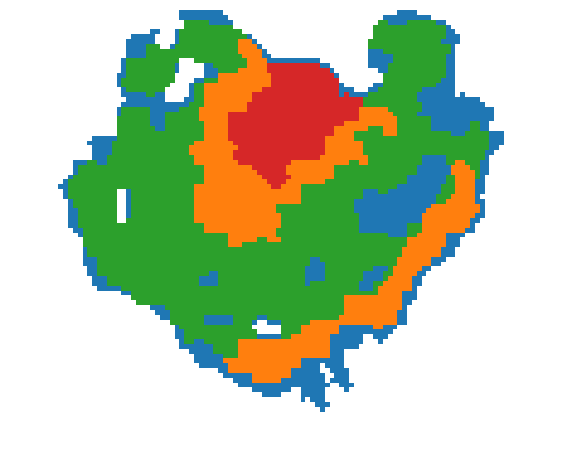

4


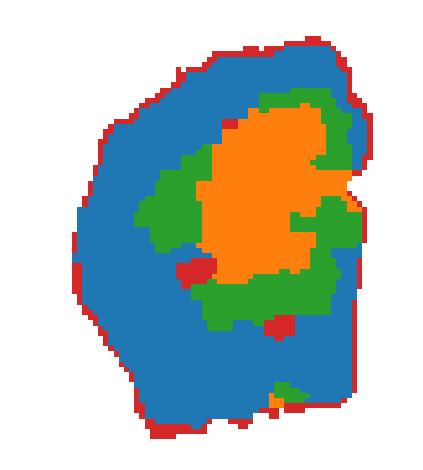

5


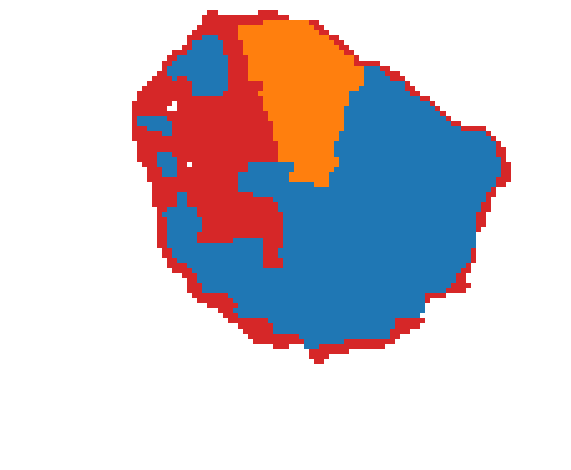

6


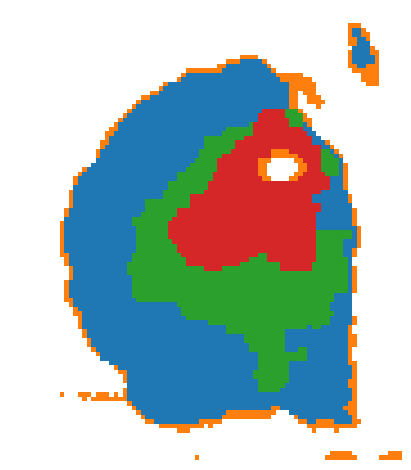

7


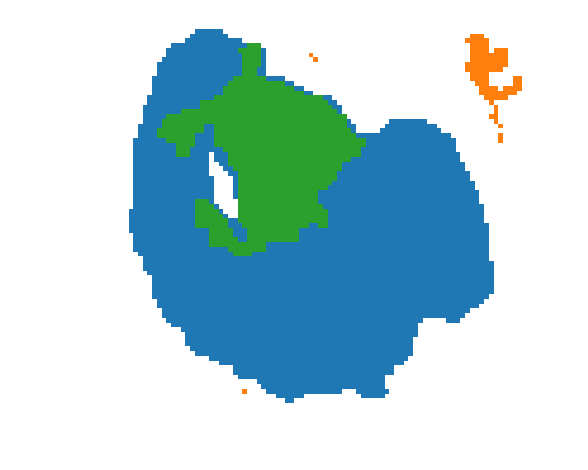

8


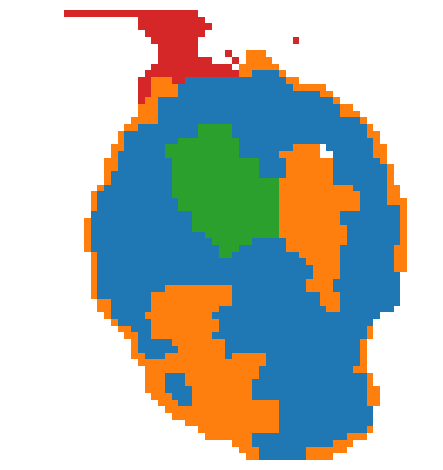

9


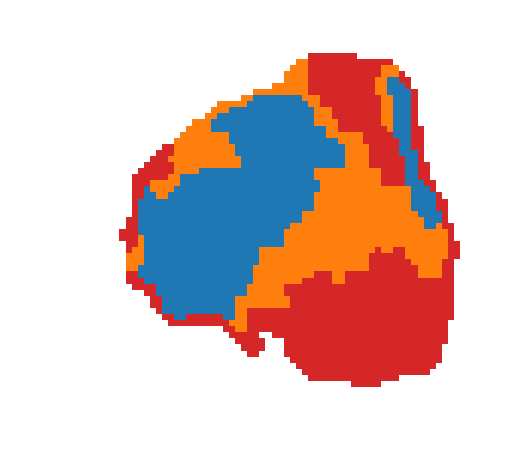

10


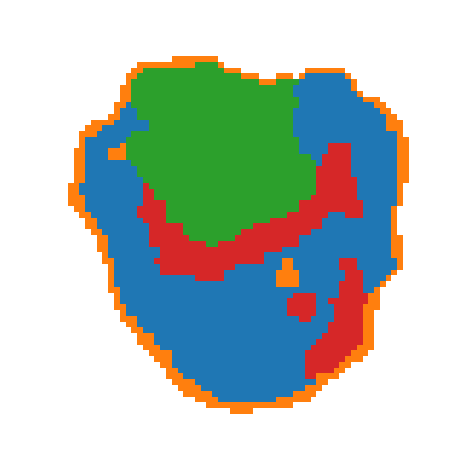

11


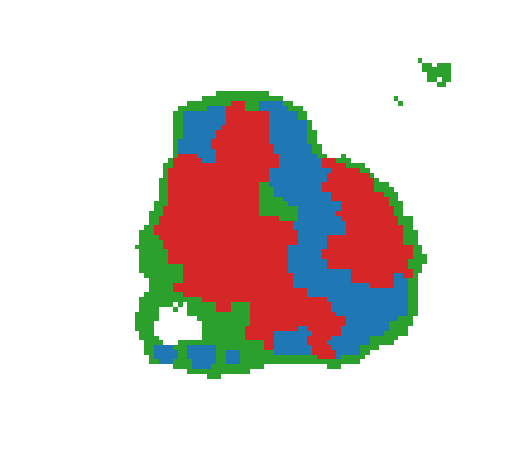

12


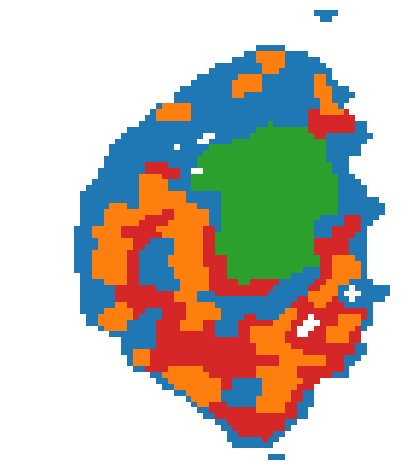

13


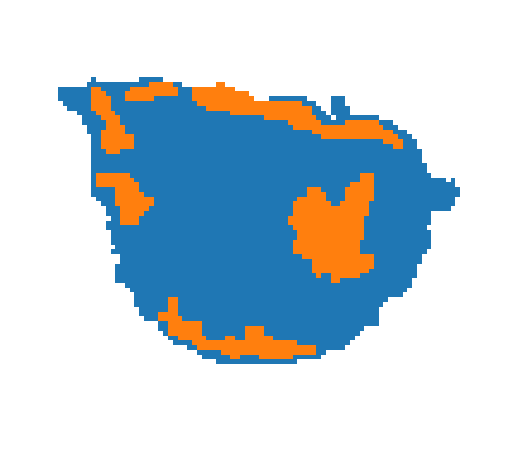

14


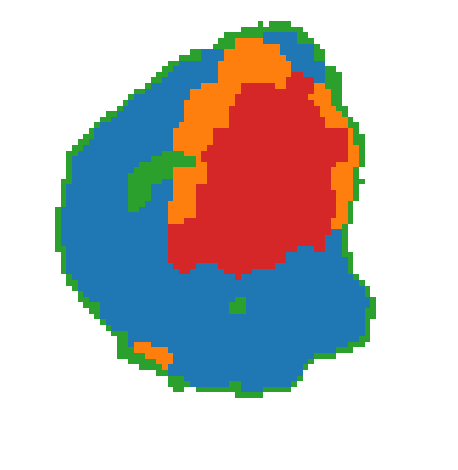

15


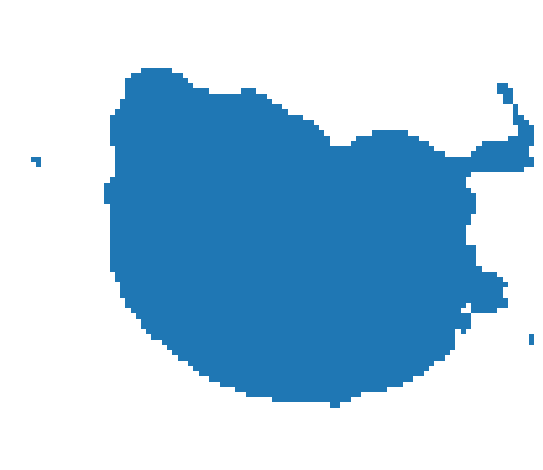

In [28]:
between_days_diffs = []

for sample_idx in range(0, len(samples_groups) * 2, 2):
  mean_vecs_0 = {}
  mean_vecs_5 = {}
  for cluster in np.delete(np.unique(cluster_labels_list[sample_idx]), 0):
    mean_vecs_0[cluster] = img_list[sample_idx][np.isin(cluster_labels_list[sample_idx],
                                               cluster)].mean(axis=0)
  for cluster in np.delete(np.unique(cluster_labels_list[sample_idx + 1]), 0):
    mean_vecs_5[cluster] = img_list[sample_idx + 1][
        np.isin(cluster_labels_list[sample_idx + 1], cluster)].mean(axis=0)

  correlation = []
  for key_1, value_1 in mean_vecs_0.items():
    for key_2, value_2 in mean_vecs_5.items():
      correlation.append((key_1, key_2, np.linalg.norm(value_1 - value_2)))

  between_days_diffs.append(correlation)

new_cluster_labels_list = []

for idx, diffs in enumerate(between_days_diffs):
  cluster_min_diff = {}
  cluster_map = {}

  for cluster_0, cluster_5, diff in diffs:
    if cluster_min_diff.get(cluster_5, np.inf) > diff:
      cluster_min_diff[cluster_5] = diff
      cluster_map[cluster_5] = cluster_0

  day_5_index = idx * 2 + 1

  new_cluster_labels_list.append(cluster_labels_list[idx * 2].copy())

  cluster_labels = cluster_labels_list[day_5_index]
  new_cluster_labels = cluster_labels.copy()

  for cluster_5, cluster_0 in cluster_map.items():
    new_cluster_labels[cluster_labels == cluster_5] = cluster_0
  
  new_cluster_labels_list.append(new_cluster_labels)

  print("Cluster map max correlation:", {key: round(value, 4) for key, value in cluster_max_corr.items()})
  print("Cluster map from day 5 to day 0:", cluster_map)

for i, new_cluster_labels in enumerate(new_cluster_labels_list):
  print(i)
  plot_clusters(new_cluster_labels, n_clusters)

In [ ]:
within_sample_cluster_correlation = []

for img, mzs, seg, cluster_labels in zip(
    img_list, mzs_list, seg_list, cluster_labels_list
):
  mean_vecs = {}
  for cluster in np.delete(np.unique(cluster_labels), 0):
    mean_vecs[cluster] = img[np.isin(cluster_labels, cluster)].mean(axis=0)
  correlation = []
  for i in range(1, n_clusters + 1):
    for j in range(i + 1, n_clusters + 1):
      correlation.append((i, j, np.corrcoef(mean_vecs[i], mean_vecs[j])[0, 1]))
  within_sample_cluster_correlation.append(correlation)

for idx, (sample, correlation) in enumerate(
    zip(np.array(samples_groups).flatten(), within_sample_cluster_correlation)
):
  for i, j, corr in correlation:
    if corr >= 0.7:
      print(idx, sample, i, j, corr)

from copy import deepcopy

new_cluster_labels_list = deepcopy(cluster_labels_list)

# Background cluster removal
new_cluster_labels_list[0][new_cluster_labels_list[0] == 1] = 0
new_cluster_labels_list[2][new_cluster_labels_list[2] == 2] = 0
new_cluster_labels_list[4][new_cluster_labels_list[4] == 2] = 0
new_cluster_labels_list[6][new_cluster_labels_list[6] == 2] = 0
new_cluster_labels_list[7][new_cluster_labels_list[7] == 4] = 0
new_cluster_labels_list[8][new_cluster_labels_list[8] == 1] = 0
new_cluster_labels_list[10][new_cluster_labels_list[10] == 3] = 0
new_cluster_labels_list[14][new_cluster_labels_list[14] == 3] = 0
""" 
# Within cluster merging based on correlation
new_cluster_labels_list[1][new_cluster_labels_list[1] == 1] = 3
new_cluster_labels_list[2][new_cluster_labels_list[2] == 1] = 2
new_cluster_labels_list[3][new_cluster_labels_list[3] == 1] = 3
new_cluster_labels_list[5][new_cluster_labels_list[5] == 1] = 3
new_cluster_labels_list[7][new_cluster_labels_list[7] == 2] = 3
new_cluster_labels_list[8][new_cluster_labels_list[8] == 2] = 4
new_cluster_labels_list[9][new_cluster_labels_list[9] == 2] = 4
new_cluster_labels_list[11][new_cluster_labels_list[11] == 2] = 3
new_cluster_labels_list[12][new_cluster_labels_list[12] == 2] = 4
new_cluster_labels_list[13][new_cluster_labels_list[13] == 2] = 1
new_cluster_labels_list[13][new_cluster_labels_list[13] == 4] = 1
new_cluster_labels_list[15][new_cluster_labels_list[15] == 3] = 1
new_cluster_labels_list[15][new_cluster_labels_list[15] == 4] = 1
"""